In [31]:
from transformers import Swinv2Config, Swinv2Model, AutoFeatureExtractor
import transformers
import os, json, glob, requests, torch, cv2
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from transformers import Swinv2ForImageClassification

In [51]:
#set default path
TRAIN_JSON_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\label\train'
VALID_JSON_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\label\val'
TEST_JSON_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\label\test'

TRAIN_IMG_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\train'
VALID_IMG_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\val'
TEST_IMG_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\test'

TRAIN_SEGMENT_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\segmentation\train'
VALID_SEGMENT_PATH = r'C:\Users\User\Desktop\Code\Github\Final_project\data\segmentation\val'




IMG_ROWS = 256
IMG_COLS = 256

In [33]:
#To get json list that contains info about the pictures.
def get_json_list_1d(json_folder_path): #returns a 1 dim array
    temp_loader = []
    json_train = []
    emotion_list_json = os.listdir(json_folder_path)

    for emotion in emotion_list_json:
        with open (json_folder_path + "\\" + emotion, "r", encoding='euc-kr') as f:
            temp_loader.append(json.load(f))     

    for i in range(len(temp_loader)):
        json_train += temp_loader[i]     

    return json_train

def get_json_list_2d(json_folder_path): #returns 2 dim array
    json_train = []
    emotion_list_json = os.listdir(json_folder_path)

    for emotion in emotion_list_json:
        with open (json_folder_path + emotion, "r", encoding='euc-kr') as f:
            json_train.append(json.load(f))     

    return json_train



Json 파일들을 읽기 쉽게 불러오기

In [52]:
#call for the functions
json_train = get_json_list_1d(TRAIN_JSON_PATH)
json_val = get_json_list_1d(VALID_JSON_PATH)




print(json_train[0].keys()) #see what keys are available
print(len(json_train))
print(len(json_val))
print(os.listdir(TRAIN_IMG_PATH))
#0 = 분노, 1 = 기쁨, 2 = 당황, 3 = 슬픔
#0 = anger, 1 = happy, 2 = panic, 3 = sadness


dict_keys(['filename', 'gender', 'age', 'isProf', 'faceExp_uploader', 'bg_uploader', 'annot_A', 'annot_B', 'annot_C'])
5382
1049
['anger', 'happy', 'panic', 'sadness']


In [35]:
# print(len(json_val_2d[1]))
# len(json_train)
print(len(os.listdir(VALID_IMG_PATH + '/' + 'happy/')))

303


파일 JSON 이랑 비교해서 빠진거 있나 확인

In [13]:
#여기는 2D 쪽을 사용해서 했었음

# filenames_json = [entry['filename'] for entry in json_val_2d[1]]
# filenames_folder = os.listdir(VALID_IMG_PATH + 'happy/')

# print(list( set(filenames_json) - set(filenames_folder)))
# print(len(list( set(filenames_json) - set(filenames_folder))))

[]
0


In [14]:
#checking if that file exist in the path
# temp = r'C:\Users\User\Downloads\Project3\val\happy'
# filenames_folder = os.listdir(temp)

# '7uji1c8ab7778bc286c3cd90077847f9a906f00b210838ba57877a29abd60ffix.jpg' in filenames_folder

False

get all images and put them into a list

In [39]:
#0 = 분노, 1 = 기쁨, 2 = 당황, 3 = 슬픔


#이미지와 레이블을 받아오기. 이미지 리사이즈만 하고 다른 전처리는 안함
#다른 전처리도 같이 진행 가능함. 아래에서 feature_extractor 에서 모델에 맞는 전처리를 해주기 때문에 여기서 진행 안함.

#designed for 1D json file
def load_image_and_label_1D(json_list, img_path):
    img_file = []
    label_list = []
    
    eng_to_num = { '분노'   : '0',
                   '기쁨'   : '1',
                   '당황'   : '2',
                   '슬픔'   : '3'             
                 }
    kr_to_en = { '분노'    : 'anger',
                 '기쁨'   : 'happy',
                 '당황'   : 'panic',
                 '슬픔'   : 'sadness'             
                 }

    
    for entry in range(len(json_list)):
        try:
            label = json_list[entry]['faceExp_uploader']
            img_dir = img_path + '/' + kr_to_en[label] + '/' + json_list[entry]['filename']
            # img_dir = img_path + kr_to_en[label] + '/' + json_list[entry]['filename']
            # img = np.array(image.load_img(img_dir, target_size=(IMG_ROWS, IMG_COLS)))/255
            img = image.load_img(img_dir, target_size=(IMG_ROWS, IMG_COLS))
            img_file.append(img)
            label_list.append(int(eng_to_num[label]))
        except Exception:
            print("Emotion " + label + " " + json_list[entry]['filename'] + " Not available")
            pass

    return img_file, label_list

In [40]:
train_img, train_label = load_image_and_label_1D(json_train, TRAIN_IMG_PATH)

Emotion 당황 twdva8d723865fa1005873a6967797c75f3dd83197f13f7daa3e3926947071al6.jpg Not available
Emotion 당황 5yid6d7ae32bf14b1343da46cfdb3fdffc8e1c64baf4fb1b175690f648a870v69.jpg Not available
Emotion 당황 bpv531e5cebdb1c00085158bb0677c5596ccabf1c8a5cb0007991571bf306wcd4.jpg Not available
Emotion 당황 s1q397a38900c1e1f950496109900e7c01f0630459790d8590010655c4090vlh0.jpg Not available
Emotion 당황 7m2k46c05803855399ea1ee1911875ee59e05640c93135c0bc91b5660456cdo8k.jpg Not available
Emotion 당황 n55yc741f09701506c7eb5ba30533db35c905ab5bf0597b5652ece03c5950ozv1.jpg Not available
Emotion 당황 bid7b3c93409e1d83514689337f6d3d63a338339d71c9ce7fded153d3576fk2ml.jpg Not available
Emotion 당황 if0lfc4b517c6597e3656dbea350e406e1b5ae4e175e460597064875909d9t40p.jpg Not available
Emotion 당황 58w153f3f5ade2ad20ec19e6744ff2ff0a54ba3520ffbef36f3f3a47af75fxuf5.jpg Not available
Emotion 당황 lhyp01dff4faf13d1b4319722dc31bb3a104a3878ab3816a03bb8acdfa3d3eomk.jpg Not available
Emotion 당황 vba0d31d23b44711180462388c8aba4424a0aa2

In [41]:
val_img, val_label = load_image_and_label_1D(json_val, VALID_IMG_PATH)


In [54]:
print(len(train_img))
# print(type(train_label[0]))
print(len(val_img))
# print(train_img[0].shape)
print(len(test_img))

5364
1049
1137


Modeling

In [48]:
from transformers import Swinv2ForImageClassification, AutoFeatureExtractor

In [49]:
model_name = "microsoft/swinv2-tiny-patch4-window8-256"


In [55]:
train_df = pd.DataFrame(columns=['image', 'label'])
train_df['image'] = train_img
train_df['label'] = train_label

val_df = pd.DataFrame(columns=['image', 'label'])
val_df['image'] = val_img
val_df['label'] = val_label



In [56]:
train_dict = train_df.to_dict('records')
val_dict = val_df.to_dict('records')


# train_dict[0]['image']
# train_dict
# print(type(train_dict[0]))

In [57]:
from datasets import Dataset
# train_ds = Dataset.from_pandas(pd.DataFrame(data=train_dict))
train_ds = Dataset.from_list(train_dict)
val_ds = Dataset.from_list(val_dict)

train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 5364
})

In [58]:
label2id = {       '분노'   : '0',
                   '기쁨'   : '1',
                   '당황'   : '2',
                   '슬픔'   : '3'             
                 }
id2label = {
    '0' : '분노',
    '1' : '기쁨',
    '2' : '당황',
    '3' : '슬픔'
}
id2label

{'0': '분노', '1': '기쁨', '2': '당황', '3': '슬픔'}

In [59]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_name)
image_processor

c:\Users\User\anaconda3\envs\my_env_py311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [60]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [61]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [20]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': 0,
 'pixel_values': tensor([[[-1.1075, -1.1418, -1.1247,  ..., -1.0733, -1.0390, -1.0904],
          [-1.1247, -1.1247, -1.1075,  ..., -1.0904, -1.0562, -1.0733],
          [-1.1075, -1.1075, -1.1075,  ..., -1.1075, -1.0733, -1.0904],
          ...,
          [-0.1486, -0.1486, -0.1314,  ...,  0.9132,  0.9303,  0.9303],
          [-0.0116, -0.0287,  0.0227,  ...,  0.9132,  0.9132,  0.9132],
          [ 0.1768,  0.1426,  0.1939,  ...,  0.9303,  0.9303,  0.8961]],
 
         [[-0.7227, -0.7577, -0.7577,  ..., -0.7402, -0.7052, -0.7577],
          [-0.7402, -0.7402, -0.7402,  ..., -0.7227, -0.6877, -0.7227],
          [-0.7227, -0.7227, -0.7402,  ..., -0.7227, -0.6877, -0.7227],
          ...,
          [-0.0049, -0.0049,  0.0126,  ...,  1.2031,  1.2206,  1.2206],
          [ 0.1527,  0.1176,  0.1702,  ...,  1.2206,  1.2206,  1.2206],
          [ 0.3277,  0.2927,  0.3452,  ...,  1.2381,  1.2381,  1.2556]],


In [21]:
model = Swinv2ForImageClassification.from_pretrained(
    model_name, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
from transformers import TrainingArguments, Trainer

batch_size = 8

model_checkpoint = model_name.split("/")[-1]

args = TrainingArguments(
    f"{model_checkpoint}-finetuned-emotions",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)

In [49]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [50]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from huggingface_hub import login

login()

In [51]:
from datasets import load_metric

metric = load_metric("accuracy")

c:\Users\User\anaconda3\envs\my_env_py311\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [52]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [53]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

  0%|          | 10/3340 [00:04<21:53,  2.54it/s]
                                                 

  0%|          | 10/3340 [00:04<21:53,  2.54it/s]


{'loss': 0.4103, 'grad_norm': 10.960575103759766, 'learning_rate': 1.4970059880239521e-06, 'epoch': 0.06}


  1%|          | 20/3340 [00:08<21:42,  2.55it/s]
                                                 

  1%|          | 20/3340 [00:08<21:42,  2.55it/s]


{'loss': 0.3885, 'grad_norm': 7.192625522613525, 'learning_rate': 2.9940119760479042e-06, 'epoch': 0.12}


  1%|          | 30/3340 [00:12<21:44,  2.54it/s]
                                                 

  1%|          | 30/3340 [00:12<21:44,  2.54it/s]


{'loss': 0.3351, 'grad_norm': 9.125064849853516, 'learning_rate': 4.4910179640718566e-06, 'epoch': 0.18}


  1%|          | 40/3340 [00:16<21:10,  2.60it/s]
                                                 

  1%|          | 40/3340 [00:16<21:10,  2.60it/s]


{'loss': 0.4101, 'grad_norm': 8.385979652404785, 'learning_rate': 5.9880239520958085e-06, 'epoch': 0.24}


  1%|▏         | 50/3340 [00:20<22:02,  2.49it/s]
                                                 

  1%|▏         | 50/3340 [00:20<22:02,  2.49it/s]


{'loss': 0.2848, 'grad_norm': 6.6132683753967285, 'learning_rate': 7.48502994011976e-06, 'epoch': 0.3}


  2%|▏         | 60/3340 [00:24<21:34,  2.53it/s]
                                                 

  2%|▏         | 60/3340 [00:24<21:34,  2.53it/s]


{'loss': 0.2408, 'grad_norm': 3.4884870052337646, 'learning_rate': 8.982035928143713e-06, 'epoch': 0.36}


  2%|▏         | 70/3340 [00:28<21:44,  2.51it/s]
                                                 

  2%|▏         | 70/3340 [00:28<21:44,  2.51it/s]


{'loss': 0.2326, 'grad_norm': 7.546187877655029, 'learning_rate': 1.0479041916167664e-05, 'epoch': 0.42}


  2%|▏         | 80/3340 [00:31<21:05,  2.58it/s]
                                                 

  2%|▏         | 80/3340 [00:31<21:05,  2.58it/s]


{'loss': 0.1683, 'grad_norm': 3.1540441513061523, 'learning_rate': 1.1976047904191617e-05, 'epoch': 0.48}


  3%|▎         | 90/3340 [00:35<20:52,  2.60it/s]
                                                 

  3%|▎         | 90/3340 [00:35<20:52,  2.60it/s]


{'loss': 0.1783, 'grad_norm': 12.268486976623535, 'learning_rate': 1.347305389221557e-05, 'epoch': 0.54}


  3%|▎         | 100/3340 [00:39<21:09,  2.55it/s]
                                                  

  3%|▎         | 100/3340 [00:39<21:09,  2.55it/s]


{'loss': 0.2002, 'grad_norm': 10.998455047607422, 'learning_rate': 1.497005988023952e-05, 'epoch': 0.6}


  3%|▎         | 110/3340 [00:43<22:08,  2.43it/s]
                                                  

  3%|▎         | 110/3340 [00:43<22:08,  2.43it/s]


{'loss': 0.1958, 'grad_norm': 7.641499996185303, 'learning_rate': 1.6467065868263474e-05, 'epoch': 0.66}


  4%|▎         | 120/3340 [00:47<21:04,  2.55it/s]
                                                  

  4%|▎         | 120/3340 [00:47<21:04,  2.55it/s]


{'loss': 0.2076, 'grad_norm': 13.053688049316406, 'learning_rate': 1.7964071856287426e-05, 'epoch': 0.72}


  4%|▍         | 130/3340 [00:53<30:45,  1.74it/s]
                                                  

  4%|▍         | 130/3340 [00:53<30:45,  1.74it/s]


{'loss': 0.1875, 'grad_norm': 8.554990768432617, 'learning_rate': 1.946107784431138e-05, 'epoch': 0.77}


  4%|▍         | 140/3340 [00:58<30:08,  1.77it/s]
                                                  

  4%|▍         | 140/3340 [00:58<30:08,  1.77it/s]


{'loss': 0.162, 'grad_norm': 8.809171676635742, 'learning_rate': 2.095808383233533e-05, 'epoch': 0.83}


  4%|▍         | 150/3340 [01:04<29:39,  1.79it/s]
                                                  

  4%|▍         | 150/3340 [01:04<29:39,  1.79it/s]


{'loss': 0.3133, 'grad_norm': 11.498887062072754, 'learning_rate': 2.245508982035928e-05, 'epoch': 0.89}


  5%|▍         | 160/3340 [01:10<29:12,  1.81it/s]
                                                  

  5%|▍         | 160/3340 [01:10<29:12,  1.81it/s]


{'loss': 0.2519, 'grad_norm': 15.94823169708252, 'learning_rate': 2.3952095808383234e-05, 'epoch': 0.95}


  5%|▌         | 167/3340 [01:14<29:25,  1.80it/s]


































































































































                     

                                                  

                                           

  5%|▌         | 167/3340 [01:22<29:25,  1.80it/s]




{'eval_loss': 0.7301743030548096, 'eval_accuracy': 0.8017159199237369, 'eval_runtime': 8.1439, 'eval_samples_per_second': 128.808, 'eval_steps_per_second': 16.208, 'epoch': 1.0}


  5%|▌         | 170/3340 [01:24<1:37:01,  1.84s/it]
                                                    

  5%|▌         | 170/3340 [01:24<1:37:01,  1.84s/it]


{'loss': 0.2529, 'grad_norm': 3.6715333461761475, 'learning_rate': 2.5449101796407187e-05, 'epoch': 1.01}


  5%|▌         | 180/3340 [01:30<30:37,  1.72it/s]  
                                                  

  5%|▌         | 180/3340 [01:30<30:37,  1.72it/s]


{'loss': 0.1996, 'grad_norm': 7.567174911499023, 'learning_rate': 2.694610778443114e-05, 'epoch': 1.07}


  6%|▌         | 190/3340 [01:35<29:31,  1.78it/s]
                                                  

  6%|▌         | 190/3340 [01:35<29:31,  1.78it/s]


{'loss': 0.2454, 'grad_norm': 10.895944595336914, 'learning_rate': 2.8443113772455092e-05, 'epoch': 1.13}


  6%|▌         | 200/3340 [01:41<30:04,  1.74it/s]
                                                  

  6%|▌         | 200/3340 [01:41<30:04,  1.74it/s]


{'loss': 0.3136, 'grad_norm': 9.362090110778809, 'learning_rate': 2.994011976047904e-05, 'epoch': 1.19}


  6%|▋         | 210/3340 [01:46<28:49,  1.81it/s]
                                                  

  6%|▋         | 210/3340 [01:46<28:49,  1.81it/s]


{'loss': 0.2522, 'grad_norm': 4.469192028045654, 'learning_rate': 3.143712574850299e-05, 'epoch': 1.25}


  7%|▋         | 220/3340 [01:52<29:04,  1.79it/s]
                                                  

  7%|▋         | 220/3340 [01:52<29:04,  1.79it/s]


{'loss': 0.2097, 'grad_norm': 10.338759422302246, 'learning_rate': 3.293413173652695e-05, 'epoch': 1.31}


  7%|▋         | 230/3340 [01:58<29:00,  1.79it/s]
                                                  

  7%|▋         | 230/3340 [01:58<29:00,  1.79it/s]


{'loss': 0.2321, 'grad_norm': 6.797539234161377, 'learning_rate': 3.4431137724550896e-05, 'epoch': 1.37}


  7%|▋         | 240/3340 [02:03<28:49,  1.79it/s]
                                                  

  7%|▋         | 240/3340 [02:03<28:49,  1.79it/s]


{'loss': 0.4725, 'grad_norm': 16.662851333618164, 'learning_rate': 3.592814371257485e-05, 'epoch': 1.43}


  7%|▋         | 250/3340 [02:09<28:32,  1.80it/s]
                                                  

  7%|▋         | 250/3340 [02:09<28:32,  1.80it/s]


{'loss': 0.2726, 'grad_norm': 8.303314208984375, 'learning_rate': 3.74251497005988e-05, 'epoch': 1.49}


  8%|▊         | 260/3340 [02:14<28:12,  1.82it/s]
                                                  

  8%|▊         | 260/3340 [02:14<28:12,  1.82it/s]


{'loss': 0.2545, 'grad_norm': 7.57240104675293, 'learning_rate': 3.892215568862276e-05, 'epoch': 1.55}


  8%|▊         | 270/3340 [02:20<28:15,  1.81it/s]
                                                  

  8%|▊         | 270/3340 [02:20<28:15,  1.81it/s]


{'loss': 0.2886, 'grad_norm': 9.298227310180664, 'learning_rate': 4.041916167664671e-05, 'epoch': 1.61}


  8%|▊         | 280/3340 [02:25<28:56,  1.76it/s]
                                                  

  8%|▊         | 280/3340 [02:25<28:56,  1.76it/s]


{'loss': 0.2846, 'grad_norm': 10.246795654296875, 'learning_rate': 4.191616766467066e-05, 'epoch': 1.67}


  9%|▊         | 290/3340 [02:31<27:34,  1.84it/s]
                                                  

  9%|▊         | 290/3340 [02:31<27:34,  1.84it/s]


{'loss': 0.3244, 'grad_norm': 14.186052322387695, 'learning_rate': 4.341317365269461e-05, 'epoch': 1.73}


  9%|▉         | 300/3340 [02:36<27:45,  1.82it/s]
                                                  

  9%|▉         | 300/3340 [02:36<27:45,  1.82it/s]


{'loss': 0.2416, 'grad_norm': 9.561830520629883, 'learning_rate': 4.491017964071856e-05, 'epoch': 1.79}


  9%|▉         | 310/3340 [02:42<28:00,  1.80it/s]
                                                  

  9%|▉         | 310/3340 [02:42<28:00,  1.80it/s]


{'loss': 0.2928, 'grad_norm': 9.262335777282715, 'learning_rate': 4.640718562874252e-05, 'epoch': 1.85}


 10%|▉         | 320/3340 [02:47<28:11,  1.79it/s]
                                                  

 10%|▉         | 320/3340 [02:47<28:11,  1.79it/s]


{'loss': 0.2565, 'grad_norm': 7.710954189300537, 'learning_rate': 4.790419161676647e-05, 'epoch': 1.91}


 10%|▉         | 330/3340 [02:53<27:15,  1.84it/s]
                                                  

 10%|▉         | 330/3340 [02:53<27:15,  1.84it/s]


{'loss': 0.2407, 'grad_norm': 7.573072910308838, 'learning_rate': 4.9401197604790424e-05, 'epoch': 1.97}


 10%|█         | 335/3340 [02:56<28:50,  1.74it/s]


































































































































                     


                                                  

                                           

 10%|█         | 335/3340 [03:04<28:50,  1.74it/s]




{'eval_loss': 0.7094589471817017, 'eval_accuracy': 0.7836034318398475, 'eval_runtime': 8.4604, 'eval_samples_per_second': 123.989, 'eval_steps_per_second': 15.602, 'epoch': 2.0}


 10%|█         | 340/3340 [03:08<1:00:38,  1.21s/it]
                                                    

 10%|█         | 340/3340 [03:08<1:00:38,  1.21s/it]


{'loss': 0.2641, 'grad_norm': 15.205129623413086, 'learning_rate': 4.99001996007984e-05, 'epoch': 2.03}


 10%|█         | 350/3340 [03:13<28:41,  1.74it/s]  
                                                  

 10%|█         | 350/3340 [03:13<28:41,  1.74it/s]


{'loss': 0.3725, 'grad_norm': 11.716263771057129, 'learning_rate': 4.973386560212908e-05, 'epoch': 2.09}


 11%|█         | 360/3340 [03:19<27:33,  1.80it/s]
                                                  

 11%|█         | 360/3340 [03:19<27:33,  1.80it/s]


{'loss': 0.2976, 'grad_norm': 20.701759338378906, 'learning_rate': 4.956753160345975e-05, 'epoch': 2.15}


 11%|█         | 370/3340 [03:25<28:05,  1.76it/s]
                                                  

 11%|█         | 370/3340 [03:25<28:05,  1.76it/s]


{'loss': 0.2945, 'grad_norm': 8.71268367767334, 'learning_rate': 4.9401197604790424e-05, 'epoch': 2.21}


 11%|█▏        | 380/3340 [03:30<27:58,  1.76it/s]
                                                  

 11%|█▏        | 380/3340 [03:30<27:58,  1.76it/s]


{'loss': 0.3487, 'grad_norm': 20.133420944213867, 'learning_rate': 4.9234863606121094e-05, 'epoch': 2.27}


 12%|█▏        | 390/3340 [03:36<26:53,  1.83it/s]
                                                  

 12%|█▏        | 390/3340 [03:36<26:53,  1.83it/s]


{'loss': 0.3313, 'grad_norm': 16.6506290435791, 'learning_rate': 4.9068529607451764e-05, 'epoch': 2.32}


 12%|█▏        | 400/3340 [03:41<27:37,  1.77it/s]
                                                  

 12%|█▏        | 400/3340 [03:41<27:37,  1.77it/s]


{'loss': 0.1964, 'grad_norm': 7.872288227081299, 'learning_rate': 4.8902195608782434e-05, 'epoch': 2.38}


 12%|█▏        | 410/3340 [03:47<27:06,  1.80it/s]
                                                  

 12%|█▏        | 410/3340 [03:47<27:06,  1.80it/s]


{'loss': 0.2734, 'grad_norm': 19.675016403198242, 'learning_rate': 4.873586161011311e-05, 'epoch': 2.44}


 13%|█▎        | 420/3340 [03:53<27:40,  1.76it/s]
                                                  

 13%|█▎        | 420/3340 [03:53<27:40,  1.76it/s]


{'loss': 0.2519, 'grad_norm': 9.35816764831543, 'learning_rate': 4.856952761144378e-05, 'epoch': 2.5}


 13%|█▎        | 430/3340 [03:58<26:13,  1.85it/s]
                                                  

 13%|█▎        | 430/3340 [03:58<26:13,  1.85it/s]


{'loss': 0.3317, 'grad_norm': 19.75969886779785, 'learning_rate': 4.840319361277446e-05, 'epoch': 2.56}


 13%|█▎        | 440/3340 [04:04<26:57,  1.79it/s]
                                                  

 13%|█▎        | 440/3340 [04:04<26:57,  1.79it/s]


{'loss': 0.2413, 'grad_norm': 12.023758888244629, 'learning_rate': 4.823685961410512e-05, 'epoch': 2.62}


 13%|█▎        | 450/3340 [04:09<26:57,  1.79it/s]
                                                  

 13%|█▎        | 450/3340 [04:09<26:57,  1.79it/s]


{'loss': 0.3109, 'grad_norm': 11.828858375549316, 'learning_rate': 4.80705256154358e-05, 'epoch': 2.68}


 14%|█▍        | 460/3340 [04:15<27:05,  1.77it/s]
                                                  

 14%|█▍        | 460/3340 [04:15<27:05,  1.77it/s]


{'loss': 0.3631, 'grad_norm': 9.819360733032227, 'learning_rate': 4.790419161676647e-05, 'epoch': 2.74}


 14%|█▍        | 470/3340 [04:21<26:48,  1.78it/s]
                                                  

 14%|█▍        | 470/3340 [04:21<26:48,  1.78it/s]


{'loss': 0.4086, 'grad_norm': 9.633036613464355, 'learning_rate': 4.7737857618097145e-05, 'epoch': 2.8}


 14%|█▍        | 480/3340 [04:26<26:16,  1.81it/s]
                                                  

 14%|█▍        | 480/3340 [04:26<26:16,  1.81it/s]


{'loss': 0.3297, 'grad_norm': 12.515183448791504, 'learning_rate': 4.7571523619427815e-05, 'epoch': 2.86}


 15%|█▍        | 490/3340 [04:32<26:36,  1.79it/s]
                                                  

 15%|█▍        | 490/3340 [04:32<26:36,  1.79it/s]


{'loss': 0.2673, 'grad_norm': 8.760054588317871, 'learning_rate': 4.7405189620758485e-05, 'epoch': 2.92}


 15%|█▍        | 500/3340 [04:37<26:00,  1.82it/s]
                                                  

 15%|█▍        | 500/3340 [04:37<26:00,  1.82it/s]


{'loss': 0.3423, 'grad_norm': 22.37627410888672, 'learning_rate': 4.7238855622089155e-05, 'epoch': 2.98}


 15%|█▌        | 503/3340 [04:39<26:20,  1.80it/s]


































































































































                     


                                                  

                                           

 15%|█▌        | 503/3340 [04:47<26:20,  1.80it/s]




{'eval_loss': 0.7015780210494995, 'eval_accuracy': 0.7883698760724499, 'eval_runtime': 8.0455, 'eval_samples_per_second': 130.384, 'eval_steps_per_second': 16.407, 'epoch': 3.0}


 15%|█▌        | 510/3340 [04:52<41:18,  1.14it/s]  
                                                  

 15%|█▌        | 510/3340 [04:52<41:18,  1.14it/s]


{'loss': 0.3667, 'grad_norm': 9.89026165008545, 'learning_rate': 4.707252162341983e-05, 'epoch': 3.04}


 16%|█▌        | 520/3340 [04:57<26:21,  1.78it/s]
                                                  

 16%|█▌        | 520/3340 [04:57<26:21,  1.78it/s]


{'loss': 0.29, 'grad_norm': 7.535145282745361, 'learning_rate': 4.69061876247505e-05, 'epoch': 3.1}


 16%|█▌        | 530/3340 [05:03<25:53,  1.81it/s]
                                                  

 16%|█▌        | 530/3340 [05:03<25:53,  1.81it/s]


{'loss': 0.3696, 'grad_norm': 12.816089630126953, 'learning_rate': 4.673985362608118e-05, 'epoch': 3.16}


 16%|█▌        | 540/3340 [05:09<25:22,  1.84it/s]
                                                  

 16%|█▌        | 540/3340 [05:09<25:22,  1.84it/s]


{'loss': 0.3464, 'grad_norm': 7.88785982131958, 'learning_rate': 4.657351962741184e-05, 'epoch': 3.22}


 16%|█▋        | 550/3340 [05:14<25:49,  1.80it/s]
                                                  

 16%|█▋        | 550/3340 [05:14<25:49,  1.80it/s]


{'loss': 0.3843, 'grad_norm': 10.986320495605469, 'learning_rate': 4.640718562874252e-05, 'epoch': 3.28}


 17%|█▋        | 560/3340 [05:20<25:17,  1.83it/s]
                                                  

 17%|█▋        | 560/3340 [05:20<25:17,  1.83it/s]


{'loss': 0.2881, 'grad_norm': 7.250551700592041, 'learning_rate': 4.624085163007319e-05, 'epoch': 3.34}


 17%|█▋        | 570/3340 [05:25<25:42,  1.80it/s]
                                                  

 17%|█▋        | 570/3340 [05:25<25:42,  1.80it/s]


{'loss': 0.4096, 'grad_norm': 13.962821006774902, 'learning_rate': 4.6074517631403865e-05, 'epoch': 3.4}


 17%|█▋        | 580/3340 [05:31<25:07,  1.83it/s]
                                                  

 17%|█▋        | 580/3340 [05:31<25:07,  1.83it/s]


{'loss': 0.3581, 'grad_norm': 20.556989669799805, 'learning_rate': 4.590818363273453e-05, 'epoch': 3.46}


 18%|█▊        | 590/3340 [05:36<25:21,  1.81it/s]
                                                  

 18%|█▊        | 590/3340 [05:36<25:21,  1.81it/s]


{'loss': 0.4109, 'grad_norm': 15.469462394714355, 'learning_rate': 4.5741849634065205e-05, 'epoch': 3.52}


 18%|█▊        | 600/3340 [05:42<25:02,  1.82it/s]
                                                  

 18%|█▊        | 600/3340 [05:42<25:02,  1.82it/s]


{'loss': 0.3548, 'grad_norm': 8.477961540222168, 'learning_rate': 4.5575515635395875e-05, 'epoch': 3.58}


 18%|█▊        | 610/3340 [05:47<25:28,  1.79it/s]
                                                  

 18%|█▊        | 610/3340 [05:47<25:28,  1.79it/s]


{'loss': 0.4291, 'grad_norm': 15.730958938598633, 'learning_rate': 4.540918163672655e-05, 'epoch': 3.64}


 19%|█▊        | 620/3340 [05:53<25:03,  1.81it/s]
                                                  

 19%|█▊        | 620/3340 [05:53<25:03,  1.81it/s]


{'loss': 0.4141, 'grad_norm': 15.376053810119629, 'learning_rate': 4.524284763805722e-05, 'epoch': 3.7}


 19%|█▉        | 630/3340 [05:58<24:28,  1.85it/s]
                                                  

 19%|█▉        | 630/3340 [05:58<24:28,  1.85it/s]


{'loss': 0.4476, 'grad_norm': 14.568710327148438, 'learning_rate': 4.507651363938789e-05, 'epoch': 3.76}


 19%|█▉        | 640/3340 [06:04<24:36,  1.83it/s]
                                                  

 19%|█▉        | 640/3340 [06:04<24:36,  1.83it/s]


{'loss': 0.509, 'grad_norm': 14.586650848388672, 'learning_rate': 4.491017964071856e-05, 'epoch': 3.82}


 19%|█▉        | 650/3340 [06:09<24:26,  1.83it/s]
                                                  

 19%|█▉        | 650/3340 [06:09<24:26,  1.83it/s]


{'loss': 0.3884, 'grad_norm': 13.514355659484863, 'learning_rate': 4.474384564204924e-05, 'epoch': 3.87}


 20%|█▉        | 660/3340 [06:15<24:37,  1.81it/s]
                                                  

 20%|█▉        | 660/3340 [06:15<24:37,  1.81it/s]


{'loss': 0.4255, 'grad_norm': 13.67029857635498, 'learning_rate': 4.457751164337991e-05, 'epoch': 3.93}


 20%|██        | 670/3340 [06:20<24:04,  1.85it/s]
                                                  

 20%|██        | 670/3340 [06:20<24:04,  1.85it/s]


{'loss': 0.4687, 'grad_norm': 16.471757888793945, 'learning_rate': 4.4411177644710586e-05, 'epoch': 3.99}


 20%|██        | 671/3340 [06:21<23:33,  1.89it/s]


































































































































                     


                                                  

                                           

 20%|██        | 671/3340 [06:29<23:33,  1.89it/s]




{'eval_loss': 0.6479951739311218, 'eval_accuracy': 0.7969494756911344, 'eval_runtime': 7.9203, 'eval_samples_per_second': 132.444, 'eval_steps_per_second': 16.666, 'epoch': 4.0}


 20%|██        | 680/3340 [06:34<30:41,  1.44it/s]  
                                                  

 20%|██        | 680/3340 [06:34<30:41,  1.44it/s]


{'loss': 0.4353, 'grad_norm': 10.711188316345215, 'learning_rate': 4.424484364604125e-05, 'epoch': 4.05}


 21%|██        | 690/3340 [06:40<24:12,  1.82it/s]
                                                  

 21%|██        | 690/3340 [06:40<24:12,  1.82it/s]


{'loss': 0.3458, 'grad_norm': 8.69890308380127, 'learning_rate': 4.4078509647371926e-05, 'epoch': 4.11}


 21%|██        | 700/3340 [06:45<23:54,  1.84it/s]
                                                  

 21%|██        | 700/3340 [06:45<23:54,  1.84it/s]


{'loss': 0.4443, 'grad_norm': 9.997675895690918, 'learning_rate': 4.3912175648702596e-05, 'epoch': 4.17}


 21%|██▏       | 710/3340 [06:51<23:43,  1.85it/s]
                                                  

 21%|██▏       | 710/3340 [06:51<23:43,  1.85it/s]


{'loss': 0.3964, 'grad_norm': 6.6480937004089355, 'learning_rate': 4.374584165003327e-05, 'epoch': 4.23}


 22%|██▏       | 720/3340 [06:56<24:18,  1.80it/s]
                                                  

 22%|██▏       | 720/3340 [06:56<24:18,  1.80it/s]


{'loss': 0.5527, 'grad_norm': 21.061498641967773, 'learning_rate': 4.357950765136394e-05, 'epoch': 4.29}


 22%|██▏       | 730/3340 [07:02<23:28,  1.85it/s]
                                                  

 22%|██▏       | 730/3340 [07:02<23:28,  1.85it/s]


{'loss': 0.4021, 'grad_norm': 9.210108757019043, 'learning_rate': 4.341317365269461e-05, 'epoch': 4.35}


 22%|██▏       | 740/3340 [07:07<23:59,  1.81it/s]
                                                  

 22%|██▏       | 740/3340 [07:07<23:59,  1.81it/s]


{'loss': 0.4965, 'grad_norm': 6.218446254730225, 'learning_rate': 4.324683965402528e-05, 'epoch': 4.41}


 22%|██▏       | 750/3340 [07:13<23:50,  1.81it/s]
                                                  

 22%|██▏       | 750/3340 [07:13<23:50,  1.81it/s]


{'loss': 0.4254, 'grad_norm': 24.4089412689209, 'learning_rate': 4.308050565535596e-05, 'epoch': 4.47}


 23%|██▎       | 760/3340 [07:19<23:55,  1.80it/s]
                                                  

 23%|██▎       | 760/3340 [07:19<23:55,  1.80it/s]


{'loss': 0.542, 'grad_norm': 14.07034969329834, 'learning_rate': 4.291417165668663e-05, 'epoch': 4.53}


 23%|██▎       | 770/3340 [07:24<23:10,  1.85it/s]
                                                  

 23%|██▎       | 770/3340 [07:24<23:10,  1.85it/s]


{'loss': 0.4754, 'grad_norm': 8.93421459197998, 'learning_rate': 4.274783765801731e-05, 'epoch': 4.59}


 23%|██▎       | 780/3340 [07:29<23:23,  1.82it/s]
                                                  

 23%|██▎       | 780/3340 [07:29<23:23,  1.82it/s]


{'loss': 0.4723, 'grad_norm': 6.090472221374512, 'learning_rate': 4.258150365934797e-05, 'epoch': 4.65}


 24%|██▎       | 790/3340 [07:35<23:24,  1.82it/s]
                                                  

 24%|██▎       | 790/3340 [07:35<23:24,  1.82it/s]


{'loss': 0.4214, 'grad_norm': 8.528217315673828, 'learning_rate': 4.241516966067865e-05, 'epoch': 4.71}


 24%|██▍       | 800/3340 [07:41<22:45,  1.86it/s]
                                                  

 24%|██▍       | 800/3340 [07:41<22:45,  1.86it/s]


{'loss': 0.5033, 'grad_norm': 12.6545991897583, 'learning_rate': 4.224883566200932e-05, 'epoch': 4.77}


 24%|██▍       | 810/3340 [07:46<23:15,  1.81it/s]
                                                  

 24%|██▍       | 810/3340 [07:46<23:15,  1.81it/s]


{'loss': 0.477, 'grad_norm': 14.964997291564941, 'learning_rate': 4.2082501663339994e-05, 'epoch': 4.83}


 25%|██▍       | 820/3340 [07:52<22:49,  1.84it/s]
                                                  

 25%|██▍       | 820/3340 [07:52<22:49,  1.84it/s]


{'loss': 0.5907, 'grad_norm': 13.434337615966797, 'learning_rate': 4.191616766467066e-05, 'epoch': 4.89}


 25%|██▍       | 830/3340 [07:57<23:13,  1.80it/s]
                                                  

 25%|██▍       | 830/3340 [07:57<23:13,  1.80it/s]


{'loss': 0.4789, 'grad_norm': 9.222450256347656, 'learning_rate': 4.1749833666001334e-05, 'epoch': 4.95}


 25%|██▌       | 838/3340 [08:02<22:36,  1.84it/s]


































































































































                     


                                                  

                                           

 25%|██▌       | 838/3340 [08:10<22:36,  1.84it/s]




{'eval_loss': 0.5132156014442444, 'eval_accuracy': 0.8160152526215443, 'eval_runtime': 8.0884, 'eval_samples_per_second': 129.691, 'eval_steps_per_second': 16.32, 'epoch': 5.0}


 25%|██▌       | 840/3340 [08:11<1:37:37,  2.34s/it]
                                                    

 25%|██▌       | 840/3340 [08:11<1:37:37,  2.34s/it]


{'loss': 0.4626, 'grad_norm': 12.845413208007812, 'learning_rate': 4.1583499667332004e-05, 'epoch': 5.01}


 25%|██▌       | 850/3340 [08:17<25:21,  1.64it/s]  
                                                  

 25%|██▌       | 850/3340 [08:17<25:21,  1.64it/s]


{'loss': 0.4936, 'grad_norm': 6.454958915710449, 'learning_rate': 4.141716566866268e-05, 'epoch': 5.07}


 26%|██▌       | 860/3340 [08:22<22:41,  1.82it/s]
                                                  

 26%|██▌       | 860/3340 [08:22<22:41,  1.82it/s]


{'loss': 0.4634, 'grad_norm': 8.519314765930176, 'learning_rate': 4.125083166999335e-05, 'epoch': 5.13}


 26%|██▌       | 870/3340 [08:28<23:05,  1.78it/s]
                                                  

 26%|██▌       | 870/3340 [08:28<23:05,  1.78it/s]


{'loss': 0.4778, 'grad_norm': 10.634246826171875, 'learning_rate': 4.108449767132402e-05, 'epoch': 5.19}


 26%|██▋       | 880/3340 [08:34<22:40,  1.81it/s]
                                                  

 26%|██▋       | 880/3340 [08:34<22:40,  1.81it/s]


{'loss': 0.4441, 'grad_norm': 9.959195137023926, 'learning_rate': 4.091816367265469e-05, 'epoch': 5.25}


 27%|██▋       | 890/3340 [08:39<22:44,  1.80it/s]
                                                  

 27%|██▋       | 890/3340 [08:39<22:44,  1.80it/s]


{'loss': 0.5051, 'grad_norm': 7.803572654724121, 'learning_rate': 4.075182967398537e-05, 'epoch': 5.31}


 27%|██▋       | 900/3340 [08:45<22:26,  1.81it/s]
                                                  

 27%|██▋       | 900/3340 [08:45<22:26,  1.81it/s]


{'loss': 0.5487, 'grad_norm': 14.378479957580566, 'learning_rate': 4.058549567531604e-05, 'epoch': 5.37}


 27%|██▋       | 910/3340 [08:50<22:26,  1.81it/s]
                                                  

 27%|██▋       | 910/3340 [08:50<22:26,  1.81it/s]


{'loss': 0.4812, 'grad_norm': 6.01740837097168, 'learning_rate': 4.041916167664671e-05, 'epoch': 5.42}


 28%|██▊       | 920/3340 [08:56<22:14,  1.81it/s]
                                                  

 28%|██▊       | 920/3340 [08:56<22:14,  1.81it/s]


{'loss': 0.4259, 'grad_norm': 7.550004005432129, 'learning_rate': 4.025282767797738e-05, 'epoch': 5.48}


 28%|██▊       | 930/3340 [09:01<21:51,  1.84it/s]
                                                  

 28%|██▊       | 930/3340 [09:01<21:51,  1.84it/s]


{'loss': 0.5069, 'grad_norm': 14.801591873168945, 'learning_rate': 4.0086493679308054e-05, 'epoch': 5.54}


 28%|██▊       | 940/3340 [09:07<21:53,  1.83it/s]
                                                  

 28%|██▊       | 940/3340 [09:07<21:53,  1.83it/s]


{'loss': 0.447, 'grad_norm': 7.926522731781006, 'learning_rate': 3.9920159680638724e-05, 'epoch': 5.6}


 28%|██▊       | 950/3340 [09:12<21:29,  1.85it/s]
                                                  

 28%|██▊       | 950/3340 [09:12<21:29,  1.85it/s]


{'loss': 0.5208, 'grad_norm': 15.849045753479004, 'learning_rate': 3.9753825681969394e-05, 'epoch': 5.66}


 29%|██▊       | 960/3340 [09:18<21:52,  1.81it/s]
                                                  

 29%|██▊       | 960/3340 [09:18<21:52,  1.81it/s]


{'loss': 0.5743, 'grad_norm': 12.452868461608887, 'learning_rate': 3.958749168330007e-05, 'epoch': 5.72}


 29%|██▉       | 970/3340 [09:23<21:08,  1.87it/s]
                                                  

 29%|██▉       | 970/3340 [09:23<21:08,  1.87it/s]


{'loss': 0.5075, 'grad_norm': 5.192020416259766, 'learning_rate': 3.942115768463074e-05, 'epoch': 5.78}


 29%|██▉       | 980/3340 [09:29<21:50,  1.80it/s]
                                                  

 29%|██▉       | 980/3340 [09:29<21:50,  1.80it/s]


{'loss': 0.457, 'grad_norm': 9.956670761108398, 'learning_rate': 3.925482368596141e-05, 'epoch': 5.84}


 30%|██▉       | 990/3340 [09:34<21:19,  1.84it/s]
                                                  

 30%|██▉       | 990/3340 [09:34<21:19,  1.84it/s]


{'loss': 0.4408, 'grad_norm': 11.043902397155762, 'learning_rate': 3.908848968729209e-05, 'epoch': 5.9}


 30%|██▉       | 1000/3340 [09:40<21:47,  1.79it/s]
                                                   

 30%|██▉       | 1000/3340 [09:40<21:47,  1.79it/s]


{'loss': 0.4417, 'grad_norm': 13.288126945495605, 'learning_rate': 3.892215568862276e-05, 'epoch': 5.96}


 30%|███       | 1006/3340 [09:43<21:48,  1.78it/s]


































































































































                     


                                                   

                                           

 30%|███       | 1006/3340 [09:52<21:48,  1.78it/s]




{'eval_loss': 0.5320664644241333, 'eval_accuracy': 0.8064823641563393, 'eval_runtime': 8.0339, 'eval_samples_per_second': 130.571, 'eval_steps_per_second': 16.43, 'epoch': 6.0}


 30%|███       | 1010/3340 [09:54<55:26,  1.43s/it]  
                                                   

 30%|███       | 1010/3340 [09:54<55:26,  1.43s/it]


{'loss': 0.4836, 'grad_norm': 10.424617767333984, 'learning_rate': 3.875582168995343e-05, 'epoch': 6.02}


 31%|███       | 1020/3340 [10:00<22:28,  1.72it/s]
                                                   

 31%|███       | 1020/3340 [10:00<22:28,  1.72it/s]


{'loss': 0.4745, 'grad_norm': 9.722286224365234, 'learning_rate': 3.85894876912841e-05, 'epoch': 6.08}


 31%|███       | 1030/3340 [10:05<21:10,  1.82it/s]
                                                   

 31%|███       | 1030/3340 [10:05<21:10,  1.82it/s]


{'loss': 0.5, 'grad_norm': 13.425250053405762, 'learning_rate': 3.8423153692614775e-05, 'epoch': 6.14}


 31%|███       | 1040/3340 [10:11<20:59,  1.83it/s]
                                                   

 31%|███       | 1040/3340 [10:11<20:59,  1.83it/s]


{'loss': 0.4625, 'grad_norm': 6.328361988067627, 'learning_rate': 3.8256819693945445e-05, 'epoch': 6.2}


 31%|███▏      | 1050/3340 [10:16<20:57,  1.82it/s]
                                                   

 31%|███▏      | 1050/3340 [10:16<20:57,  1.82it/s]


{'loss': 0.5142, 'grad_norm': 12.468230247497559, 'learning_rate': 3.8090485695276115e-05, 'epoch': 6.26}


 32%|███▏      | 1060/3340 [10:22<20:40,  1.84it/s]
                                                   

 32%|███▏      | 1060/3340 [10:22<20:40,  1.84it/s]


{'loss': 0.4077, 'grad_norm': 10.808314323425293, 'learning_rate': 3.7924151696606785e-05, 'epoch': 6.32}


 32%|███▏      | 1070/3340 [10:27<20:49,  1.82it/s]
                                                   

 32%|███▏      | 1070/3340 [10:27<20:49,  1.82it/s]


{'loss': 0.5124, 'grad_norm': 11.397859573364258, 'learning_rate': 3.775781769793746e-05, 'epoch': 6.38}


 32%|███▏      | 1080/3340 [10:33<20:45,  1.81it/s]
                                                   

 32%|███▏      | 1080/3340 [10:33<20:45,  1.81it/s]


{'loss': 0.3871, 'grad_norm': 4.529419898986816, 'learning_rate': 3.759148369926813e-05, 'epoch': 6.44}


 33%|███▎      | 1090/3340 [10:38<20:47,  1.80it/s]
                                                   

 33%|███▎      | 1090/3340 [10:38<20:47,  1.80it/s]


{'loss': 0.4546, 'grad_norm': 13.067590713500977, 'learning_rate': 3.74251497005988e-05, 'epoch': 6.5}


 33%|███▎      | 1100/3340 [10:43<14:51,  2.51it/s]
                                                   

 33%|███▎      | 1100/3340 [10:43<14:51,  2.51it/s]


{'loss': 0.4464, 'grad_norm': 8.941795349121094, 'learning_rate': 3.725881570192948e-05, 'epoch': 6.56}


 33%|███▎      | 1110/3340 [10:47<14:15,  2.61it/s]
                                                   

 33%|███▎      | 1110/3340 [10:47<14:15,  2.61it/s]


{'loss': 0.4156, 'grad_norm': 6.314669609069824, 'learning_rate': 3.709248170326015e-05, 'epoch': 6.62}


 34%|███▎      | 1120/3340 [10:51<14:38,  2.53it/s]
                                                   

 34%|███▎      | 1120/3340 [10:51<14:38,  2.53it/s]


{'loss': 0.5158, 'grad_norm': 12.252542495727539, 'learning_rate': 3.692614770459082e-05, 'epoch': 6.68}


 34%|███▍      | 1130/3340 [10:55<14:10,  2.60it/s]
                                                   

 34%|███▍      | 1130/3340 [10:55<14:10,  2.60it/s]


{'loss': 0.4017, 'grad_norm': 8.056780815124512, 'learning_rate': 3.675981370592149e-05, 'epoch': 6.74}


 34%|███▍      | 1140/3340 [10:59<18:43,  1.96it/s]
                                                   

 34%|███▍      | 1140/3340 [10:59<18:43,  1.96it/s]


{'loss': 0.3504, 'grad_norm': 6.237992763519287, 'learning_rate': 3.6593479707252166e-05, 'epoch': 6.8}


 34%|███▍      | 1150/3340 [11:05<19:32,  1.87it/s]
                                                   

 34%|███▍      | 1150/3340 [11:05<19:32,  1.87it/s]


{'loss': 0.3978, 'grad_norm': 9.671211242675781, 'learning_rate': 3.6427145708582836e-05, 'epoch': 6.86}


 35%|███▍      | 1160/3340 [11:10<20:00,  1.82it/s]
                                                   

 35%|███▍      | 1160/3340 [11:10<20:00,  1.82it/s]


{'loss': 0.4211, 'grad_norm': 10.172355651855469, 'learning_rate': 3.6260811709913506e-05, 'epoch': 6.92}


 35%|███▌      | 1170/3340 [11:16<19:31,  1.85it/s]
                                                   

 35%|███▌      | 1170/3340 [11:16<19:31,  1.85it/s]


{'loss': 0.435, 'grad_norm': 9.352071762084961, 'learning_rate': 3.6094477711244176e-05, 'epoch': 6.97}


 35%|███▌      | 1174/3340 [11:18<20:04,  1.80it/s]


































































































































                     


                                                   

                                           

 35%|███▌      | 1174/3340 [11:26<20:04,  1.80it/s]




{'eval_loss': 0.576992928981781, 'eval_accuracy': 0.8093422306959008, 'eval_runtime': 8.1288, 'eval_samples_per_second': 129.047, 'eval_steps_per_second': 16.238, 'epoch': 7.0}


 35%|███▌      | 1180/3340 [11:30<35:50,  1.00it/s]  
                                                   

 35%|███▌      | 1180/3340 [11:30<35:50,  1.00it/s]


{'loss': 0.3645, 'grad_norm': 12.904959678649902, 'learning_rate': 3.592814371257485e-05, 'epoch': 7.03}


 36%|███▌      | 1190/3340 [11:35<20:16,  1.77it/s]
                                                   

 36%|███▌      | 1190/3340 [11:35<20:16,  1.77it/s]


{'loss': 0.4082, 'grad_norm': 8.032413482666016, 'learning_rate': 3.576180971390552e-05, 'epoch': 7.09}


 36%|███▌      | 1200/3340 [11:41<19:42,  1.81it/s]
                                                   

 36%|███▌      | 1200/3340 [11:41<19:42,  1.81it/s]


{'loss': 0.4452, 'grad_norm': 12.337096214294434, 'learning_rate': 3.55954757152362e-05, 'epoch': 7.15}


 36%|███▌      | 1210/3340 [11:46<19:35,  1.81it/s]
                                                   

 36%|███▌      | 1210/3340 [11:46<19:35,  1.81it/s]


{'loss': 0.4518, 'grad_norm': 12.804167747497559, 'learning_rate': 3.542914171656686e-05, 'epoch': 7.21}


 37%|███▋      | 1220/3340 [11:52<19:15,  1.84it/s]
                                                   

 37%|███▋      | 1220/3340 [11:52<19:15,  1.84it/s]


{'loss': 0.4156, 'grad_norm': 9.41336727142334, 'learning_rate': 3.526280771789754e-05, 'epoch': 7.27}


 37%|███▋      | 1230/3340 [11:58<19:19,  1.82it/s]
                                                   

 37%|███▋      | 1230/3340 [11:58<19:19,  1.82it/s]


{'loss': 0.4716, 'grad_norm': 8.111486434936523, 'learning_rate': 3.509647371922821e-05, 'epoch': 7.33}


 37%|███▋      | 1240/3340 [12:03<19:06,  1.83it/s]
                                                   

 37%|███▋      | 1240/3340 [12:03<19:06,  1.83it/s]


{'loss': 0.4189, 'grad_norm': 6.630052089691162, 'learning_rate': 3.4930139720558886e-05, 'epoch': 7.39}


 37%|███▋      | 1250/3340 [12:09<19:02,  1.83it/s]
                                                   

 37%|███▋      | 1250/3340 [12:09<19:02,  1.83it/s]


{'loss': 0.3883, 'grad_norm': 13.34854507446289, 'learning_rate': 3.4763805721889556e-05, 'epoch': 7.45}


 38%|███▊      | 1260/3340 [12:14<19:02,  1.82it/s]
                                                   

 38%|███▊      | 1260/3340 [12:14<19:02,  1.82it/s]


{'loss': 0.4819, 'grad_norm': 10.413986206054688, 'learning_rate': 3.4597471723220226e-05, 'epoch': 7.51}


 38%|███▊      | 1270/3340 [12:20<18:47,  1.84it/s]
                                                   

 38%|███▊      | 1270/3340 [12:20<18:47,  1.84it/s]


{'loss': 0.397, 'grad_norm': 6.9878363609313965, 'learning_rate': 3.4431137724550896e-05, 'epoch': 7.57}


 38%|███▊      | 1280/3340 [12:25<19:16,  1.78it/s]
                                                   

 38%|███▊      | 1280/3340 [12:25<19:16,  1.78it/s]


{'loss': 0.4918, 'grad_norm': 6.6817474365234375, 'learning_rate': 3.426480372588157e-05, 'epoch': 7.63}


 39%|███▊      | 1290/3340 [12:31<18:37,  1.84it/s]
                                                   

 39%|███▊      | 1290/3340 [12:31<18:37,  1.84it/s]


{'loss': 0.4053, 'grad_norm': 8.586297988891602, 'learning_rate': 3.409846972721224e-05, 'epoch': 7.69}


 39%|███▉      | 1300/3340 [12:36<18:42,  1.82it/s]
                                                   

 39%|███▉      | 1300/3340 [12:36<18:42,  1.82it/s]


{'loss': 0.3887, 'grad_norm': 6.881846904754639, 'learning_rate': 3.393213572854291e-05, 'epoch': 7.75}


 39%|███▉      | 1310/3340 [12:42<18:15,  1.85it/s]
                                                   

 39%|███▉      | 1310/3340 [12:42<18:15,  1.85it/s]


{'loss': 0.4187, 'grad_norm': 9.012574195861816, 'learning_rate': 3.376580172987358e-05, 'epoch': 7.81}


 40%|███▉      | 1320/3340 [12:47<18:27,  1.82it/s]
                                                   

 40%|███▉      | 1320/3340 [12:47<18:27,  1.82it/s]


{'loss': 0.3467, 'grad_norm': 5.658350467681885, 'learning_rate': 3.359946773120426e-05, 'epoch': 7.87}


 40%|███▉      | 1330/3340 [12:53<18:35,  1.80it/s]
                                                   

 40%|███▉      | 1330/3340 [12:53<18:35,  1.80it/s]


{'loss': 0.4563, 'grad_norm': 7.825368881225586, 'learning_rate': 3.343313373253493e-05, 'epoch': 7.93}


 40%|████      | 1340/3340 [12:59<18:17,  1.82it/s]
                                                   

 40%|████      | 1340/3340 [12:59<18:17,  1.82it/s]


{'loss': 0.4106, 'grad_norm': 10.295827865600586, 'learning_rate': 3.326679973386561e-05, 'epoch': 7.99}


 40%|████      | 1342/3340 [13:00<17:51,  1.86it/s]


































































































































                     


                                                   

                                           

 40%|████      | 1342/3340 [13:08<17:51,  1.86it/s]




{'eval_loss': 0.5649912357330322, 'eval_accuracy': 0.8188751191611058, 'eval_runtime': 8.1818, 'eval_samples_per_second': 128.211, 'eval_steps_per_second': 16.133, 'epoch': 8.0}


 40%|████      | 1350/3340 [13:13<25:29,  1.30it/s]  
                                                   

 40%|████      | 1350/3340 [13:13<25:29,  1.30it/s]


{'loss': 0.3984, 'grad_norm': 9.255845069885254, 'learning_rate': 3.310046573519627e-05, 'epoch': 8.05}


 41%|████      | 1360/3340 [13:18<18:24,  1.79it/s]
                                                   

 41%|████      | 1360/3340 [13:18<18:24,  1.79it/s]


{'loss': 0.3949, 'grad_norm': 18.463470458984375, 'learning_rate': 3.293413173652695e-05, 'epoch': 8.11}


 41%|████      | 1370/3340 [13:24<18:05,  1.81it/s]
                                                   

 41%|████      | 1370/3340 [13:24<18:05,  1.81it/s]


{'loss': 0.345, 'grad_norm': 12.822425842285156, 'learning_rate': 3.276779773785762e-05, 'epoch': 8.17}


 41%|████▏     | 1380/3340 [13:29<17:49,  1.83it/s]
                                                   

 41%|████▏     | 1380/3340 [13:29<17:49,  1.83it/s]


{'loss': 0.4353, 'grad_norm': 7.737868785858154, 'learning_rate': 3.2601463739188294e-05, 'epoch': 8.23}


 42%|████▏     | 1390/3340 [13:35<17:31,  1.85it/s]
                                                   

 42%|████▏     | 1390/3340 [13:35<17:31,  1.85it/s]


{'loss': 0.4794, 'grad_norm': 16.8526554107666, 'learning_rate': 3.2435129740518964e-05, 'epoch': 8.29}


 42%|████▏     | 1400/3340 [13:40<17:40,  1.83it/s]
                                                   

 42%|████▏     | 1400/3340 [13:41<17:40,  1.83it/s]


{'loss': 0.3782, 'grad_norm': 6.869993209838867, 'learning_rate': 3.2268795741849634e-05, 'epoch': 8.35}


 42%|████▏     | 1410/3340 [13:45<13:48,  2.33it/s]
                                                   

 42%|████▏     | 1410/3340 [13:45<13:48,  2.33it/s]


{'loss': 0.492, 'grad_norm': 6.812426567077637, 'learning_rate': 3.2102461743180304e-05, 'epoch': 8.41}


 43%|████▎     | 1420/3340 [13:49<12:47,  2.50it/s]
                                                   

 43%|████▎     | 1420/3340 [13:49<12:47,  2.50it/s]


{'loss': 0.4332, 'grad_norm': 9.126212120056152, 'learning_rate': 3.193612774451098e-05, 'epoch': 8.46}


 43%|████▎     | 1430/3340 [13:53<12:25,  2.56it/s]
                                                   

 43%|████▎     | 1430/3340 [13:53<12:25,  2.56it/s]


{'loss': 0.325, 'grad_norm': 8.745487213134766, 'learning_rate': 3.176979374584165e-05, 'epoch': 8.52}


 43%|████▎     | 1440/3340 [13:57<12:09,  2.60it/s]
                                                   

 43%|████▎     | 1440/3340 [13:57<12:09,  2.60it/s]


{'loss': 0.4335, 'grad_norm': 8.982501983642578, 'learning_rate': 3.160345974717233e-05, 'epoch': 8.58}


 43%|████▎     | 1450/3340 [14:01<12:07,  2.60it/s]
                                                   

 43%|████▎     | 1450/3340 [14:01<12:07,  2.60it/s]


{'loss': 0.3782, 'grad_norm': 9.547370910644531, 'learning_rate': 3.143712574850299e-05, 'epoch': 8.64}


 44%|████▎     | 1460/3340 [14:05<12:12,  2.57it/s]
                                                   

 44%|████▎     | 1460/3340 [14:05<12:12,  2.57it/s]


{'loss': 0.3393, 'grad_norm': 7.764449119567871, 'learning_rate': 3.127079174983367e-05, 'epoch': 8.7}


 44%|████▍     | 1470/3340 [14:09<12:26,  2.51it/s]
                                                   

 44%|████▍     | 1470/3340 [14:09<12:26,  2.51it/s]


{'loss': 0.4551, 'grad_norm': 10.022067070007324, 'learning_rate': 3.110445775116434e-05, 'epoch': 8.76}


 44%|████▍     | 1480/3340 [14:13<12:24,  2.50it/s]
                                                   

 44%|████▍     | 1480/3340 [14:13<12:24,  2.50it/s]


{'loss': 0.4265, 'grad_norm': 11.975818634033203, 'learning_rate': 3.0938123752495015e-05, 'epoch': 8.82}


 45%|████▍     | 1490/3340 [14:17<12:22,  2.49it/s]
                                                   

 45%|████▍     | 1490/3340 [14:17<12:22,  2.49it/s]


{'loss': 0.4035, 'grad_norm': 7.445915222167969, 'learning_rate': 3.0771789753825685e-05, 'epoch': 8.88}


 45%|████▍     | 1500/3340 [14:21<11:53,  2.58it/s]
                                                   

 45%|████▍     | 1500/3340 [14:21<11:53,  2.58it/s]


{'loss': 0.4216, 'grad_norm': 9.522339820861816, 'learning_rate': 3.0605455755156355e-05, 'epoch': 8.94}


 45%|████▌     | 1509/3340 [14:24<11:53,  2.57it/s]
























































































                     


                                                   

                                           

 45%|████▌     | 1509/3340 [14:30<11:53,  2.57it/s]




{'eval_loss': 0.5534749627113342, 'eval_accuracy': 0.8131553860819828, 'eval_runtime': 5.806, 'eval_samples_per_second': 180.675, 'eval_steps_per_second': 22.735, 'epoch': 9.0}


 45%|████▌     | 1510/3340 [14:31<1:07:44,  2.22s/it]
                                                     

 45%|████▌     | 1510/3340 [14:31<1:07:44,  2.22s/it]


{'loss': 0.3988, 'grad_norm': 8.445043563842773, 'learning_rate': 3.0439121756487028e-05, 'epoch': 9.0}


 46%|████▌     | 1520/3340 [14:35<13:39,  2.22it/s]  
                                                   

 46%|████▌     | 1520/3340 [14:35<13:39,  2.22it/s]


{'loss': 0.3127, 'grad_norm': 8.678711891174316, 'learning_rate': 3.02727877578177e-05, 'epoch': 9.06}


 46%|████▌     | 1530/3340 [14:39<11:48,  2.56it/s]
                                                   

 46%|████▌     | 1530/3340 [14:39<11:48,  2.56it/s]


{'loss': 0.3069, 'grad_norm': 12.920584678649902, 'learning_rate': 3.010645375914837e-05, 'epoch': 9.12}


 46%|████▌     | 1540/3340 [14:43<11:59,  2.50it/s]
                                                   

 46%|████▌     | 1540/3340 [14:43<11:59,  2.50it/s]


{'loss': 0.3452, 'grad_norm': 9.785375595092773, 'learning_rate': 2.994011976047904e-05, 'epoch': 9.18}


 46%|████▋     | 1550/3340 [14:47<11:37,  2.57it/s]
                                                   

 46%|████▋     | 1550/3340 [14:47<11:37,  2.57it/s]


{'loss': 0.4301, 'grad_norm': 9.365363121032715, 'learning_rate': 2.9773785761809715e-05, 'epoch': 9.24}


 47%|████▋     | 1560/3340 [14:51<11:18,  2.62it/s]
                                                   

 47%|████▋     | 1560/3340 [14:51<11:18,  2.62it/s]


{'loss': 0.3818, 'grad_norm': 14.742838859558105, 'learning_rate': 2.960745176314039e-05, 'epoch': 9.3}


 47%|████▋     | 1570/3340 [14:55<11:37,  2.54it/s]
                                                   

 47%|████▋     | 1570/3340 [14:55<11:37,  2.54it/s]


{'loss': 0.3931, 'grad_norm': 9.188835144042969, 'learning_rate': 2.944111776447106e-05, 'epoch': 9.36}


 47%|████▋     | 1580/3340 [14:58<11:10,  2.63it/s]
                                                   

 47%|████▋     | 1580/3340 [14:58<11:10,  2.63it/s]


{'loss': 0.3637, 'grad_norm': 9.99288272857666, 'learning_rate': 2.9274783765801732e-05, 'epoch': 9.42}


 48%|████▊     | 1590/3340 [15:02<11:36,  2.51it/s]
                                                   

 48%|████▊     | 1590/3340 [15:02<11:36,  2.51it/s]


{'loss': 0.3637, 'grad_norm': 7.853627681732178, 'learning_rate': 2.9108449767132402e-05, 'epoch': 9.48}


 48%|████▊     | 1600/3340 [15:06<11:28,  2.53it/s]
                                                   

 48%|████▊     | 1600/3340 [15:06<11:28,  2.53it/s]


{'loss': 0.3329, 'grad_norm': 8.52716064453125, 'learning_rate': 2.8942115768463075e-05, 'epoch': 9.54}


 48%|████▊     | 1610/3340 [15:10<11:36,  2.49it/s]
                                                   

 48%|████▊     | 1610/3340 [15:10<11:36,  2.49it/s]


{'loss': 0.4248, 'grad_norm': 16.682146072387695, 'learning_rate': 2.877578176979375e-05, 'epoch': 9.6}


 49%|████▊     | 1620/3340 [15:15<14:41,  1.95it/s]
                                                   

 49%|████▊     | 1620/3340 [15:15<14:41,  1.95it/s]


{'loss': 0.4467, 'grad_norm': 14.418134689331055, 'learning_rate': 2.860944777112442e-05, 'epoch': 9.66}


 49%|████▉     | 1630/3340 [15:21<15:58,  1.78it/s]
                                                   

 49%|████▉     | 1630/3340 [15:21<15:58,  1.78it/s]


{'loss': 0.4349, 'grad_norm': 9.702448844909668, 'learning_rate': 2.8443113772455092e-05, 'epoch': 9.72}


 49%|████▉     | 1640/3340 [15:26<15:53,  1.78it/s]
                                                   

 49%|████▉     | 1640/3340 [15:26<15:53,  1.78it/s]


{'loss': 0.3623, 'grad_norm': 5.453344345092773, 'learning_rate': 2.8276779773785762e-05, 'epoch': 9.78}


 49%|████▉     | 1650/3340 [15:32<15:39,  1.80it/s]
                                                   

 49%|████▉     | 1650/3340 [15:32<15:39,  1.80it/s]


{'loss': 0.306, 'grad_norm': 8.831154823303223, 'learning_rate': 2.8110445775116436e-05, 'epoch': 9.84}


 50%|████▉     | 1660/3340 [15:37<15:25,  1.82it/s]
                                                   

 50%|████▉     | 1660/3340 [15:37<15:25,  1.82it/s]


{'loss': 0.4286, 'grad_norm': 12.066120147705078, 'learning_rate': 2.7944111776447106e-05, 'epoch': 9.9}


 50%|█████     | 1670/3340 [15:43<15:33,  1.79it/s]
                                                   

 50%|█████     | 1670/3340 [15:43<15:33,  1.79it/s]


{'loss': 0.3786, 'grad_norm': 11.502985954284668, 'learning_rate': 2.777777777777778e-05, 'epoch': 9.96}


 50%|█████     | 1677/3340 [15:47<15:28,  1.79it/s]


































































































































                     


                                                   

                                           

 50%|█████     | 1677/3340 [15:55<15:28,  1.79it/s]




{'eval_loss': 0.5744514465332031, 'eval_accuracy': 0.8179218303145853, 'eval_runtime': 8.133, 'eval_samples_per_second': 128.981, 'eval_steps_per_second': 16.23, 'epoch': 10.0}


 50%|█████     | 1680/3340 [15:57<51:04,  1.85s/it]  
                                                   

 50%|█████     | 1680/3340 [15:57<51:04,  1.85s/it]


{'loss': 0.3646, 'grad_norm': 5.245243072509766, 'learning_rate': 2.7611443779108453e-05, 'epoch': 10.01}


 51%|█████     | 1690/3340 [16:03<16:20,  1.68it/s]
                                                   

 51%|█████     | 1690/3340 [16:03<16:20,  1.68it/s]


{'loss': 0.3196, 'grad_norm': 5.654598712921143, 'learning_rate': 2.7445109780439123e-05, 'epoch': 10.07}


 51%|█████     | 1700/3340 [16:09<15:28,  1.77it/s]
                                                   

 51%|█████     | 1700/3340 [16:09<15:28,  1.77it/s]


{'loss': 0.3444, 'grad_norm': 7.564880847930908, 'learning_rate': 2.7278775781769793e-05, 'epoch': 10.13}


 51%|█████     | 1710/3340 [16:14<13:47,  1.97it/s]
                                                   

 51%|█████     | 1710/3340 [16:14<13:47,  1.97it/s]


{'loss': 0.3808, 'grad_norm': 4.542025089263916, 'learning_rate': 2.7112441783100466e-05, 'epoch': 10.19}


 51%|█████▏    | 1720/3340 [16:19<13:35,  1.99it/s]
                                                   

 51%|█████▏    | 1720/3340 [16:19<13:35,  1.99it/s]


{'loss': 0.404, 'grad_norm': 11.678935050964355, 'learning_rate': 2.694610778443114e-05, 'epoch': 10.25}


 52%|█████▏    | 1730/3340 [16:24<13:40,  1.96it/s]
                                                   

 52%|█████▏    | 1730/3340 [16:24<13:40,  1.96it/s]


{'loss': 0.3495, 'grad_norm': 8.487076759338379, 'learning_rate': 2.6779773785761813e-05, 'epoch': 10.31}


 52%|█████▏    | 1740/3340 [16:29<13:29,  1.98it/s]
                                                   

 52%|█████▏    | 1740/3340 [16:29<13:29,  1.98it/s]


{'loss': 0.3961, 'grad_norm': 15.556700706481934, 'learning_rate': 2.661343978709248e-05, 'epoch': 10.37}


 52%|█████▏    | 1750/3340 [16:34<13:32,  1.96it/s]
                                                   

 52%|█████▏    | 1750/3340 [16:34<13:32,  1.96it/s]


{'loss': 0.4335, 'grad_norm': 9.496986389160156, 'learning_rate': 2.6447105788423153e-05, 'epoch': 10.43}


 53%|█████▎    | 1760/3340 [16:39<13:27,  1.96it/s]
                                                   

 53%|█████▎    | 1760/3340 [16:39<13:27,  1.96it/s]


{'loss': 0.3737, 'grad_norm': 9.640027046203613, 'learning_rate': 2.6280771789753826e-05, 'epoch': 10.49}


 53%|█████▎    | 1770/3340 [16:45<13:10,  1.99it/s]
                                                   

 53%|█████▎    | 1770/3340 [16:45<13:10,  1.99it/s]


{'loss': 0.3499, 'grad_norm': 7.124043941497803, 'learning_rate': 2.61144377910845e-05, 'epoch': 10.55}


 53%|█████▎    | 1780/3340 [16:50<13:20,  1.95it/s]
                                                   

 53%|█████▎    | 1780/3340 [16:50<13:20,  1.95it/s]


{'loss': 0.3441, 'grad_norm': 9.196694374084473, 'learning_rate': 2.594810379241517e-05, 'epoch': 10.61}


 54%|█████▎    | 1790/3340 [16:55<13:16,  1.95it/s]
                                                   

 54%|█████▎    | 1790/3340 [16:55<13:16,  1.95it/s]


{'loss': 0.3237, 'grad_norm': 12.974782943725586, 'learning_rate': 2.578176979374584e-05, 'epoch': 10.67}


 54%|█████▍    | 1800/3340 [17:00<13:57,  1.84it/s]
                                                   

 54%|█████▍    | 1800/3340 [17:00<13:57,  1.84it/s]


{'loss': 0.3443, 'grad_norm': 12.906362533569336, 'learning_rate': 2.5615435795076513e-05, 'epoch': 10.73}


 54%|█████▍    | 1810/3340 [17:06<14:08,  1.80it/s]
                                                   

 54%|█████▍    | 1810/3340 [17:06<14:08,  1.80it/s]


{'loss': 0.4281, 'grad_norm': 12.726845741271973, 'learning_rate': 2.5449101796407187e-05, 'epoch': 10.79}


 54%|█████▍    | 1820/3340 [17:11<13:47,  1.84it/s]
                                                   

 54%|█████▍    | 1820/3340 [17:11<13:47,  1.84it/s]


{'loss': 0.4143, 'grad_norm': 10.000526428222656, 'learning_rate': 2.528276779773786e-05, 'epoch': 10.85}


 55%|█████▍    | 1830/3340 [17:17<14:00,  1.80it/s]
                                                   

 55%|█████▍    | 1830/3340 [17:17<14:00,  1.80it/s]


{'loss': 0.3897, 'grad_norm': 11.937750816345215, 'learning_rate': 2.5116433799068527e-05, 'epoch': 10.91}


 55%|█████▌    | 1840/3340 [17:23<13:38,  1.83it/s]
                                                   

 55%|█████▌    | 1840/3340 [17:23<13:38,  1.83it/s]


{'loss': 0.3536, 'grad_norm': 14.427199363708496, 'learning_rate': 2.49500998003992e-05, 'epoch': 10.97}


 55%|█████▌    | 1845/3340 [17:25<13:45,  1.81it/s]


































































































































                     


                                                   

                                           

 55%|█████▌    | 1845/3340 [17:33<13:45,  1.81it/s]




{'eval_loss': 0.6321552395820618, 'eval_accuracy': 0.8045757864632984, 'eval_runtime': 8.0005, 'eval_samples_per_second': 131.117, 'eval_steps_per_second': 16.499, 'epoch': 11.0}


 55%|█████▌    | 1850/3340 [17:37<29:05,  1.17s/it]  
                                                   

 55%|█████▌    | 1850/3340 [17:37<29:05,  1.17s/it]


{'loss': 0.3835, 'grad_norm': 9.323545455932617, 'learning_rate': 2.4783765801729874e-05, 'epoch': 11.03}


 56%|█████▌    | 1860/3340 [17:42<14:00,  1.76it/s]
                                                   

 56%|█████▌    | 1860/3340 [17:42<14:00,  1.76it/s]


{'loss': 0.3393, 'grad_norm': 8.078957557678223, 'learning_rate': 2.4617431803060547e-05, 'epoch': 11.09}


 56%|█████▌    | 1870/3340 [17:48<13:23,  1.83it/s]
                                                   

 56%|█████▌    | 1870/3340 [17:48<13:23,  1.83it/s]


{'loss': 0.3286, 'grad_norm': 9.700143814086914, 'learning_rate': 2.4451097804391217e-05, 'epoch': 11.15}


 56%|█████▋    | 1880/3340 [17:53<13:20,  1.82it/s]
                                                   

 56%|█████▋    | 1880/3340 [17:53<13:20,  1.82it/s]


{'loss': 0.3359, 'grad_norm': 5.738262176513672, 'learning_rate': 2.428476380572189e-05, 'epoch': 11.21}


 57%|█████▋    | 1890/3340 [17:59<12:31,  1.93it/s]
                                                   

 57%|█████▋    | 1890/3340 [17:59<12:31,  1.93it/s]


{'loss': 0.3545, 'grad_norm': 7.936123371124268, 'learning_rate': 2.411842980705256e-05, 'epoch': 11.27}


 57%|█████▋    | 1900/3340 [18:04<13:07,  1.83it/s]
                                                   

 57%|█████▋    | 1900/3340 [18:04<13:07,  1.83it/s]


{'loss': 0.3608, 'grad_norm': 8.06057071685791, 'learning_rate': 2.3952095808383234e-05, 'epoch': 11.33}


 57%|█████▋    | 1910/3340 [18:09<12:43,  1.87it/s]
                                                   

 57%|█████▋    | 1910/3340 [18:09<12:43,  1.87it/s]


{'loss': 0.4166, 'grad_norm': 10.899771690368652, 'learning_rate': 2.3785761809713907e-05, 'epoch': 11.39}


 57%|█████▋    | 1920/3340 [18:15<12:37,  1.88it/s]
                                                   

 57%|█████▋    | 1920/3340 [18:15<12:37,  1.88it/s]


{'loss': 0.3939, 'grad_norm': 13.915310859680176, 'learning_rate': 2.3619427811044577e-05, 'epoch': 11.45}


 58%|█████▊    | 1930/3340 [18:20<12:35,  1.87it/s]
                                                   

 58%|█████▊    | 1930/3340 [18:20<12:35,  1.87it/s]


{'loss': 0.3284, 'grad_norm': 11.563372611999512, 'learning_rate': 2.345309381237525e-05, 'epoch': 11.51}


 58%|█████▊    | 1940/3340 [18:25<12:30,  1.87it/s]
                                                   

 58%|█████▊    | 1940/3340 [18:25<12:30,  1.87it/s]


{'loss': 0.3991, 'grad_norm': 8.064857482910156, 'learning_rate': 2.328675981370592e-05, 'epoch': 11.56}


 58%|█████▊    | 1950/3340 [18:31<11:53,  1.95it/s]
                                                   

 58%|█████▊    | 1950/3340 [18:31<11:53,  1.95it/s]


{'loss': 0.3335, 'grad_norm': 10.125249862670898, 'learning_rate': 2.3120425815036594e-05, 'epoch': 11.62}


 59%|█████▊    | 1960/3340 [18:36<11:35,  1.98it/s]
                                                   

 59%|█████▊    | 1960/3340 [18:36<11:35,  1.98it/s]


{'loss': 0.3497, 'grad_norm': 10.096261024475098, 'learning_rate': 2.2954091816367264e-05, 'epoch': 11.68}


 59%|█████▉    | 1970/3340 [18:41<11:30,  1.99it/s]
                                                   

 59%|█████▉    | 1970/3340 [18:41<11:30,  1.99it/s]


{'loss': 0.4256, 'grad_norm': 10.476616859436035, 'learning_rate': 2.2787757817697938e-05, 'epoch': 11.74}


 59%|█████▉    | 1980/3340 [18:46<11:16,  2.01it/s]
                                                   

 59%|█████▉    | 1980/3340 [18:46<11:16,  2.01it/s]


{'loss': 0.3427, 'grad_norm': 7.7694010734558105, 'learning_rate': 2.262142381902861e-05, 'epoch': 11.8}


 60%|█████▉    | 1990/3340 [18:51<11:13,  2.00it/s]
                                                   

 60%|█████▉    | 1990/3340 [18:51<11:13,  2.00it/s]


{'loss': 0.2918, 'grad_norm': 12.91002368927002, 'learning_rate': 2.245508982035928e-05, 'epoch': 11.86}


 60%|█████▉    | 2000/3340 [18:56<11:07,  2.01it/s]
                                                   

 60%|█████▉    | 2000/3340 [18:56<11:07,  2.01it/s]


{'loss': 0.3115, 'grad_norm': 5.4102783203125, 'learning_rate': 2.2288755821689955e-05, 'epoch': 11.92}


 60%|██████    | 2010/3340 [19:01<11:02,  2.01it/s]
                                                   

 60%|██████    | 2010/3340 [19:01<11:02,  2.01it/s]


{'loss': 0.4842, 'grad_norm': 13.296221733093262, 'learning_rate': 2.2122421823020625e-05, 'epoch': 11.98}


 60%|██████    | 2013/3340 [19:02<10:52,  2.03it/s]


































































































































                     


                                                   

                                           

 60%|██████    | 2013/3340 [19:10<10:52,  2.03it/s]




{'eval_loss': 0.7200241684913635, 'eval_accuracy': 0.8102955195424214, 'eval_runtime': 7.5216, 'eval_samples_per_second': 139.465, 'eval_steps_per_second': 17.549, 'epoch': 12.0}


 60%|██████    | 2020/3340 [19:14<14:57,  1.47it/s]  
                                                   

 60%|██████    | 2020/3340 [19:14<14:57,  1.47it/s]


{'loss': 0.3576, 'grad_norm': 12.630990982055664, 'learning_rate': 2.1956087824351298e-05, 'epoch': 12.04}


 61%|██████    | 2030/3340 [19:17<06:26,  3.39it/s]
                                                   

 61%|██████    | 2030/3340 [19:17<06:26,  3.39it/s]


{'loss': 0.2713, 'grad_norm': 4.814639568328857, 'learning_rate': 2.178975382568197e-05, 'epoch': 12.1}


 61%|██████    | 2040/3340 [19:19<05:59,  3.62it/s]
                                                   

 61%|██████    | 2040/3340 [19:19<05:59,  3.62it/s]


{'loss': 0.3697, 'grad_norm': 6.43457555770874, 'learning_rate': 2.162341982701264e-05, 'epoch': 12.16}


 61%|██████▏   | 2050/3340 [19:22<06:06,  3.52it/s]
                                                   

 61%|██████▏   | 2050/3340 [19:22<06:06,  3.52it/s]


{'loss': 0.3419, 'grad_norm': 8.580708503723145, 'learning_rate': 2.1457085828343315e-05, 'epoch': 12.22}


 62%|██████▏   | 2060/3340 [19:25<06:05,  3.50it/s]
                                                   

 62%|██████▏   | 2060/3340 [19:25<06:05,  3.50it/s]


{'loss': 0.3912, 'grad_norm': 9.967264175415039, 'learning_rate': 2.1290751829673985e-05, 'epoch': 12.28}


 62%|██████▏   | 2070/3340 [19:28<06:19,  3.35it/s]
                                                   

 62%|██████▏   | 2070/3340 [19:28<06:19,  3.35it/s]


{'loss': 0.4224, 'grad_norm': 6.109950065612793, 'learning_rate': 2.112441783100466e-05, 'epoch': 12.34}


 62%|██████▏   | 2080/3340 [19:31<05:54,  3.55it/s]
                                                   

 62%|██████▏   | 2080/3340 [19:31<05:54,  3.55it/s]


{'loss': 0.3622, 'grad_norm': 9.962430953979492, 'learning_rate': 2.095808383233533e-05, 'epoch': 12.4}


 63%|██████▎   | 2090/3340 [19:34<05:53,  3.53it/s]
                                                   

 63%|██████▎   | 2090/3340 [19:34<05:53,  3.53it/s]


{'loss': 0.3441, 'grad_norm': 12.075277328491211, 'learning_rate': 2.0791749833666002e-05, 'epoch': 12.46}


 63%|██████▎   | 2100/3340 [19:37<05:51,  3.52it/s]
                                                   

 63%|██████▎   | 2100/3340 [19:37<05:51,  3.52it/s]


{'loss': 0.3849, 'grad_norm': 10.377482414245605, 'learning_rate': 2.0625415834996675e-05, 'epoch': 12.52}


 63%|██████▎   | 2110/3340 [19:40<05:41,  3.60it/s]
                                                   

 63%|██████▎   | 2110/3340 [19:40<05:41,  3.60it/s]


{'loss': 0.3449, 'grad_norm': 5.997406482696533, 'learning_rate': 2.0459081836327345e-05, 'epoch': 12.58}


 63%|██████▎   | 2120/3340 [19:42<05:36,  3.63it/s]
                                                   

 63%|██████▎   | 2120/3340 [19:42<05:36,  3.63it/s]


{'loss': 0.4266, 'grad_norm': 8.99052906036377, 'learning_rate': 2.029274783765802e-05, 'epoch': 12.64}


 64%|██████▍   | 2130/3340 [19:45<05:39,  3.56it/s]
                                                   

 64%|██████▍   | 2130/3340 [19:45<05:39,  3.56it/s]


{'loss': 0.3531, 'grad_norm': 7.397541522979736, 'learning_rate': 2.012641383898869e-05, 'epoch': 12.7}


 64%|██████▍   | 2140/3340 [19:48<05:39,  3.53it/s]
                                                   

 64%|██████▍   | 2140/3340 [19:48<05:39,  3.53it/s]


{'loss': 0.3661, 'grad_norm': 7.874513626098633, 'learning_rate': 1.9960079840319362e-05, 'epoch': 12.76}


 64%|██████▍   | 2150/3340 [19:51<05:34,  3.56it/s]
                                                   

 64%|██████▍   | 2150/3340 [19:51<05:34,  3.56it/s]


{'loss': 0.3058, 'grad_norm': 6.360593318939209, 'learning_rate': 1.9793745841650036e-05, 'epoch': 12.82}


 65%|██████▍   | 2160/3340 [19:54<05:24,  3.64it/s]
                                                   

 65%|██████▍   | 2160/3340 [19:54<05:24,  3.64it/s]


{'loss': 0.3303, 'grad_norm': 6.71933126449585, 'learning_rate': 1.9627411842980706e-05, 'epoch': 12.88}


 65%|██████▍   | 2170/3340 [19:56<05:31,  3.53it/s]
                                                   

 65%|██████▍   | 2170/3340 [19:56<05:31,  3.53it/s]


{'loss': 0.3235, 'grad_norm': 8.794792175292969, 'learning_rate': 1.946107784431138e-05, 'epoch': 12.94}


 65%|██████▌   | 2180/3340 [19:59<05:30,  3.51it/s]
                                                   

 65%|██████▌   | 2180/3340 [19:59<05:30,  3.51it/s]


{'loss': 0.3095, 'grad_norm': 8.178886413574219, 'learning_rate': 1.929474384564205e-05, 'epoch': 13.0}





































































                     


                                                   

                                           

 65%|██████▌   | 2180/3340 [20:04<05:30,  3.51it/s]




{'eval_loss': 0.6996090412139893, 'eval_accuracy': 0.8112488083889419, 'eval_runtime': 4.2804, 'eval_samples_per_second': 245.068, 'eval_steps_per_second': 30.838, 'epoch': 13.0}


 66%|██████▌   | 2190/3340 [20:07<06:46,  2.83it/s]
                                                   

 66%|██████▌   | 2190/3340 [20:07<06:46,  2.83it/s]


{'loss': 0.3508, 'grad_norm': 7.6686553955078125, 'learning_rate': 1.9128409846972723e-05, 'epoch': 13.06}


 66%|██████▌   | 2200/3340 [20:10<05:33,  3.42it/s]
                                                   

 66%|██████▌   | 2200/3340 [20:10<05:33,  3.42it/s]


{'loss': 0.3617, 'grad_norm': 9.841043472290039, 'learning_rate': 1.8962075848303393e-05, 'epoch': 13.11}


 66%|██████▌   | 2210/3340 [20:13<05:28,  3.44it/s]
                                                   

 66%|██████▌   | 2210/3340 [20:13<05:28,  3.44it/s]


{'loss': 0.29, 'grad_norm': 9.942082405090332, 'learning_rate': 1.8795741849634066e-05, 'epoch': 13.17}


 66%|██████▋   | 2220/3340 [20:16<05:35,  3.34it/s]
                                                   

 66%|██████▋   | 2220/3340 [20:16<05:35,  3.34it/s]


{'loss': 0.3966, 'grad_norm': 9.216142654418945, 'learning_rate': 1.862940785096474e-05, 'epoch': 13.23}


 67%|██████▋   | 2230/3340 [20:19<05:35,  3.31it/s]
                                                   

 67%|██████▋   | 2230/3340 [20:19<05:35,  3.31it/s]


{'loss': 0.2934, 'grad_norm': 9.825368881225586, 'learning_rate': 1.846307385229541e-05, 'epoch': 13.29}


 67%|██████▋   | 2240/3340 [20:23<08:37,  2.12it/s]
                                                   

 67%|██████▋   | 2240/3340 [20:23<08:37,  2.12it/s]


{'loss': 0.3119, 'grad_norm': 4.988765239715576, 'learning_rate': 1.8296739853626083e-05, 'epoch': 13.35}


 67%|██████▋   | 2250/3340 [20:28<09:20,  1.95it/s]
                                                   

 67%|██████▋   | 2250/3340 [20:28<09:20,  1.95it/s]


{'loss': 0.3111, 'grad_norm': 10.849027633666992, 'learning_rate': 1.8130405854956753e-05, 'epoch': 13.41}


 68%|██████▊   | 2260/3340 [20:33<09:08,  1.97it/s]
                                                   

 68%|██████▊   | 2260/3340 [20:33<09:08,  1.97it/s]


{'loss': 0.294, 'grad_norm': 12.157093048095703, 'learning_rate': 1.7964071856287426e-05, 'epoch': 13.47}


 68%|██████▊   | 2270/3340 [20:38<09:06,  1.96it/s]
                                                   

 68%|██████▊   | 2270/3340 [20:38<09:06,  1.96it/s]


{'loss': 0.3112, 'grad_norm': 7.045677661895752, 'learning_rate': 1.77977378576181e-05, 'epoch': 13.53}


 68%|██████▊   | 2280/3340 [20:43<08:57,  1.97it/s]
                                                   

 68%|██████▊   | 2280/3340 [20:43<08:57,  1.97it/s]


{'loss': 0.4064, 'grad_norm': 5.302694320678711, 'learning_rate': 1.763140385894877e-05, 'epoch': 13.59}


 69%|██████▊   | 2290/3340 [20:49<08:49,  1.98it/s]
                                                   

 69%|██████▊   | 2290/3340 [20:49<08:49,  1.98it/s]


{'loss': 0.2905, 'grad_norm': 10.64548110961914, 'learning_rate': 1.7465069860279443e-05, 'epoch': 13.65}


 69%|██████▉   | 2300/3340 [20:54<08:48,  1.97it/s]
                                                   

 69%|██████▉   | 2300/3340 [20:54<08:48,  1.97it/s]


{'loss': 0.3326, 'grad_norm': 7.559818744659424, 'learning_rate': 1.7298735861610113e-05, 'epoch': 13.71}


 69%|██████▉   | 2310/3340 [20:59<08:48,  1.95it/s]
                                                   

 69%|██████▉   | 2310/3340 [20:59<08:48,  1.95it/s]


{'loss': 0.3394, 'grad_norm': 7.901926517486572, 'learning_rate': 1.7132401862940787e-05, 'epoch': 13.77}


 69%|██████▉   | 2320/3340 [21:04<08:40,  1.96it/s]
                                                   

 69%|██████▉   | 2320/3340 [21:04<08:40,  1.96it/s]


{'loss': 0.3075, 'grad_norm': 7.691340446472168, 'learning_rate': 1.6966067864271457e-05, 'epoch': 13.83}


 70%|██████▉   | 2330/3340 [21:09<08:30,  1.98it/s]
                                                   

 70%|██████▉   | 2330/3340 [21:09<08:30,  1.98it/s]


{'loss': 0.3504, 'grad_norm': 6.2563395500183105, 'learning_rate': 1.679973386560213e-05, 'epoch': 13.89}


 70%|███████   | 2340/3340 [21:14<08:23,  1.99it/s]
                                                   

 70%|███████   | 2340/3340 [21:14<08:23,  1.99it/s]


{'loss': 0.2603, 'grad_norm': 6.873688697814941, 'learning_rate': 1.6633399866932804e-05, 'epoch': 13.95}


 70%|███████   | 2348/3340 [21:18<08:25,  1.96it/s]


































































































































                     


                                                   

                                           

 70%|███████   | 2348/3340 [21:26<08:25,  1.96it/s]




{'eval_loss': 0.7003843188285828, 'eval_accuracy': 0.8064823641563393, 'eval_runtime': 7.3428, 'eval_samples_per_second': 142.861, 'eval_steps_per_second': 17.977, 'epoch': 14.0}


 70%|███████   | 2350/3340 [21:27<35:50,  2.17s/it]
                                                   

 70%|███████   | 2350/3340 [21:27<35:50,  2.17s/it]


{'loss': 0.3533, 'grad_norm': 11.458070755004883, 'learning_rate': 1.6467065868263474e-05, 'epoch': 14.01}


 71%|███████   | 2360/3340 [21:32<09:09,  1.78it/s]
                                                   

 71%|███████   | 2360/3340 [21:32<09:09,  1.78it/s]


{'loss': 0.3194, 'grad_norm': 8.457056045532227, 'learning_rate': 1.6300731869594147e-05, 'epoch': 14.07}


 71%|███████   | 2370/3340 [21:37<08:15,  1.96it/s]
                                                   

 71%|███████   | 2370/3340 [21:37<08:15,  1.96it/s]


{'loss': 0.2607, 'grad_norm': 2.8758866786956787, 'learning_rate': 1.6134397870924817e-05, 'epoch': 14.13}


 71%|███████▏  | 2380/3340 [21:43<08:05,  1.98it/s]
                                                   

 71%|███████▏  | 2380/3340 [21:43<08:05,  1.98it/s]


{'loss': 0.2653, 'grad_norm': 7.556164264678955, 'learning_rate': 1.596806387225549e-05, 'epoch': 14.19}


 72%|███████▏  | 2390/3340 [21:48<08:05,  1.96it/s]
                                                   

 72%|███████▏  | 2390/3340 [21:48<08:05,  1.96it/s]


{'loss': 0.3439, 'grad_norm': 14.573066711425781, 'learning_rate': 1.5801729873586164e-05, 'epoch': 14.25}


 72%|███████▏  | 2400/3340 [21:53<07:57,  1.97it/s]
                                                   

 72%|███████▏  | 2400/3340 [21:53<07:57,  1.97it/s]


{'loss': 0.34, 'grad_norm': 12.460274696350098, 'learning_rate': 1.5635395874916834e-05, 'epoch': 14.31}


 72%|███████▏  | 2410/3340 [21:58<07:55,  1.96it/s]
                                                   

 72%|███████▏  | 2410/3340 [21:58<07:55,  1.96it/s]


{'loss': 0.3114, 'grad_norm': 6.49027156829834, 'learning_rate': 1.5469061876247507e-05, 'epoch': 14.37}


 72%|███████▏  | 2420/3340 [22:03<07:46,  1.97it/s]
                                                   

 72%|███████▏  | 2420/3340 [22:03<07:46,  1.97it/s]


{'loss': 0.3333, 'grad_norm': 4.00046968460083, 'learning_rate': 1.5302727877578177e-05, 'epoch': 14.43}


 73%|███████▎  | 2430/3340 [22:08<07:42,  1.97it/s]
                                                   

 73%|███████▎  | 2430/3340 [22:08<07:42,  1.97it/s]


{'loss': 0.3641, 'grad_norm': 10.793068885803223, 'learning_rate': 1.513639387890885e-05, 'epoch': 14.49}


 73%|███████▎  | 2440/3340 [22:13<07:35,  1.97it/s]
                                                   

 73%|███████▎  | 2440/3340 [22:13<07:35,  1.97it/s]


{'loss': 0.3296, 'grad_norm': 4.077005386352539, 'learning_rate': 1.497005988023952e-05, 'epoch': 14.55}


 73%|███████▎  | 2450/3340 [22:18<07:34,  1.96it/s]
                                                   

 73%|███████▎  | 2450/3340 [22:18<07:34,  1.96it/s]


{'loss': 0.2579, 'grad_norm': 6.533083915710449, 'learning_rate': 1.4803725881570194e-05, 'epoch': 14.61}


 74%|███████▎  | 2460/3340 [22:23<07:24,  1.98it/s]
                                                   

 74%|███████▎  | 2460/3340 [22:23<07:24,  1.98it/s]


{'loss': 0.3357, 'grad_norm': 4.220314025878906, 'learning_rate': 1.4637391882900866e-05, 'epoch': 14.66}


 74%|███████▍  | 2470/3340 [22:28<07:17,  1.99it/s]
                                                   

 74%|███████▍  | 2470/3340 [22:28<07:17,  1.99it/s]


{'loss': 0.2505, 'grad_norm': 7.446957111358643, 'learning_rate': 1.4471057884231538e-05, 'epoch': 14.72}


 74%|███████▍  | 2480/3340 [22:33<07:10,  2.00it/s]
                                                   

 74%|███████▍  | 2480/3340 [22:33<07:10,  2.00it/s]


{'loss': 0.288, 'grad_norm': 10.239314079284668, 'learning_rate': 1.430472388556221e-05, 'epoch': 14.78}


 75%|███████▍  | 2490/3340 [22:38<07:08,  1.98it/s]
                                                   

 75%|███████▍  | 2490/3340 [22:38<07:08,  1.98it/s]


{'loss': 0.2969, 'grad_norm': 9.007420539855957, 'learning_rate': 1.4138389886892881e-05, 'epoch': 14.84}


 75%|███████▍  | 2500/3340 [22:43<07:09,  1.96it/s]
                                                   

 75%|███████▍  | 2500/3340 [22:44<07:09,  1.96it/s]


{'loss': 0.2814, 'grad_norm': 9.914080619812012, 'learning_rate': 1.3972055888223553e-05, 'epoch': 14.9}


 75%|███████▌  | 2510/3340 [22:49<07:01,  1.97it/s]
                                                   

 75%|███████▌  | 2510/3340 [22:49<07:01,  1.97it/s]


{'loss': 0.2838, 'grad_norm': 10.052656173706055, 'learning_rate': 1.3805721889554226e-05, 'epoch': 14.96}


 75%|███████▌  | 2516/3340 [22:52<06:56,  1.98it/s]
































































































































                     


                                                   

                                           

 75%|███████▌  | 2516/3340 [22:59<06:56,  1.98it/s]




{'eval_loss': 0.6331220269203186, 'eval_accuracy': 0.8226882745471878, 'eval_runtime': 7.2646, 'eval_samples_per_second': 144.398, 'eval_steps_per_second': 18.17, 'epoch': 15.0}


 75%|███████▌  | 2520/3340 [23:01<17:51,  1.31s/it]
                                                   

 75%|███████▌  | 2520/3340 [23:01<17:51,  1.31s/it]


{'loss': 0.3199, 'grad_norm': 9.092655181884766, 'learning_rate': 1.3639387890884896e-05, 'epoch': 15.02}


 76%|███████▌  | 2530/3340 [23:07<07:14,  1.86it/s]
                                                   

 76%|███████▌  | 2530/3340 [23:07<07:14,  1.86it/s]


{'loss': 0.2324, 'grad_norm': 4.129884243011475, 'learning_rate': 1.347305389221557e-05, 'epoch': 15.08}


 76%|███████▌  | 2540/3340 [23:12<06:49,  1.95it/s]
                                                   

 76%|███████▌  | 2540/3340 [23:12<06:49,  1.95it/s]


{'loss': 0.2886, 'grad_norm': 9.138650894165039, 'learning_rate': 1.330671989354624e-05, 'epoch': 15.14}


 76%|███████▋  | 2550/3340 [23:17<06:42,  1.96it/s]
                                                   

 76%|███████▋  | 2550/3340 [23:17<06:42,  1.96it/s]


{'loss': 0.3332, 'grad_norm': 5.073493003845215, 'learning_rate': 1.3140385894876913e-05, 'epoch': 15.2}


 77%|███████▋  | 2560/3340 [23:22<06:36,  1.97it/s]
                                                   

 77%|███████▋  | 2560/3340 [23:22<06:36,  1.97it/s]


{'loss': 0.3684, 'grad_norm': 9.780904769897461, 'learning_rate': 1.2974051896207585e-05, 'epoch': 15.26}


 77%|███████▋  | 2570/3340 [23:27<06:31,  1.97it/s]
                                                   

 77%|███████▋  | 2570/3340 [23:27<06:31,  1.97it/s]


{'loss': 0.3083, 'grad_norm': 7.168571472167969, 'learning_rate': 1.2807717897538257e-05, 'epoch': 15.32}


 77%|███████▋  | 2580/3340 [23:32<06:28,  1.96it/s]
                                                   

 77%|███████▋  | 2580/3340 [23:32<06:28,  1.96it/s]


{'loss': 0.2705, 'grad_norm': 7.2480645179748535, 'learning_rate': 1.264138389886893e-05, 'epoch': 15.38}


 78%|███████▊  | 2590/3340 [23:37<06:22,  1.96it/s]
                                                   

 78%|███████▊  | 2590/3340 [23:37<06:22,  1.96it/s]


{'loss': 0.34, 'grad_norm': 11.398120880126953, 'learning_rate': 1.24750499001996e-05, 'epoch': 15.44}


 78%|███████▊  | 2600/3340 [23:42<06:17,  1.96it/s]
                                                   

 78%|███████▊  | 2600/3340 [23:42<06:17,  1.96it/s]


{'loss': 0.372, 'grad_norm': 15.102729797363281, 'learning_rate': 1.2308715901530274e-05, 'epoch': 15.5}


 78%|███████▊  | 2610/3340 [23:48<06:09,  1.98it/s]
                                                   

 78%|███████▊  | 2610/3340 [23:48<06:09,  1.98it/s]


{'loss': 0.3185, 'grad_norm': 5.952316761016846, 'learning_rate': 1.2142381902860945e-05, 'epoch': 15.56}


 78%|███████▊  | 2620/3340 [23:53<06:05,  1.97it/s]
                                                   

 78%|███████▊  | 2620/3340 [23:53<06:05,  1.97it/s]


{'loss': 0.2524, 'grad_norm': 7.276609420776367, 'learning_rate': 1.1976047904191617e-05, 'epoch': 15.62}


 79%|███████▊  | 2630/3340 [23:58<05:58,  1.98it/s]
                                                   

 79%|███████▊  | 2630/3340 [23:58<05:58,  1.98it/s]


{'loss': 0.383, 'grad_norm': 10.400064468383789, 'learning_rate': 1.1809713905522289e-05, 'epoch': 15.68}


 79%|███████▉  | 2640/3340 [24:03<05:58,  1.95it/s]
                                                   

 79%|███████▉  | 2640/3340 [24:03<05:58,  1.95it/s]


{'loss': 0.3251, 'grad_norm': 8.426358222961426, 'learning_rate': 1.164337990685296e-05, 'epoch': 15.74}


 79%|███████▉  | 2650/3340 [24:08<05:50,  1.97it/s]
                                                   

 79%|███████▉  | 2650/3340 [24:08<05:50,  1.97it/s]


{'loss': 0.2685, 'grad_norm': 9.584868431091309, 'learning_rate': 1.1477045908183632e-05, 'epoch': 15.8}


 80%|███████▉  | 2660/3340 [24:13<05:41,  1.99it/s]
                                                   

 80%|███████▉  | 2660/3340 [24:13<05:41,  1.99it/s]


{'loss': 0.3732, 'grad_norm': 13.510111808776855, 'learning_rate': 1.1310711909514306e-05, 'epoch': 15.86}


 80%|███████▉  | 2670/3340 [24:18<05:42,  1.96it/s]
                                                   

 80%|███████▉  | 2670/3340 [24:18<05:42,  1.96it/s]


{'loss': 0.3048, 'grad_norm': 8.642741203308105, 'learning_rate': 1.1144377910844977e-05, 'epoch': 15.92}


 80%|████████  | 2680/3340 [24:23<05:32,  1.99it/s]
                                                   

 80%|████████  | 2680/3340 [24:23<05:32,  1.99it/s]


{'loss': 0.3449, 'grad_norm': 7.956551551818848, 'learning_rate': 1.0978043912175649e-05, 'epoch': 15.98}


 80%|████████  | 2684/3340 [24:25<05:25,  2.01it/s]


































































































































                     


                                                   

                                           

 80%|████████  | 2684/3340 [24:33<05:25,  2.01it/s]




{'eval_loss': 0.6788099408149719, 'eval_accuracy': 0.8122020972354623, 'eval_runtime': 7.36, 'eval_samples_per_second': 142.527, 'eval_steps_per_second': 17.935, 'epoch': 16.0}


 81%|████████  | 2690/3340 [24:36<09:53,  1.10it/s]
                                                   

 81%|████████  | 2690/3340 [24:36<09:53,  1.10it/s]


{'loss': 0.3369, 'grad_norm': 8.361177444458008, 'learning_rate': 1.081170991350632e-05, 'epoch': 16.04}


 81%|████████  | 2700/3340 [24:41<05:36,  1.90it/s]
                                                   

 81%|████████  | 2700/3340 [24:42<05:36,  1.90it/s]


{'loss': 0.294, 'grad_norm': 7.654923915863037, 'learning_rate': 1.0645375914836992e-05, 'epoch': 16.1}


 81%|████████  | 2710/3340 [24:47<05:18,  1.98it/s]
                                                   

 81%|████████  | 2710/3340 [24:47<05:18,  1.98it/s]


{'loss': 0.3216, 'grad_norm': 12.203278541564941, 'learning_rate': 1.0479041916167664e-05, 'epoch': 16.15}


 81%|████████▏ | 2720/3340 [24:52<05:16,  1.96it/s]
                                                   

 81%|████████▏ | 2720/3340 [24:52<05:16,  1.96it/s]


{'loss': 0.3363, 'grad_norm': 14.927398681640625, 'learning_rate': 1.0312707917498338e-05, 'epoch': 16.21}


 82%|████████▏ | 2730/3340 [24:57<05:12,  1.95it/s]
                                                   

 82%|████████▏ | 2730/3340 [24:57<05:12,  1.95it/s]


{'loss': 0.2875, 'grad_norm': 12.235952377319336, 'learning_rate': 1.014637391882901e-05, 'epoch': 16.27}


 82%|████████▏ | 2740/3340 [25:02<05:03,  1.98it/s]
                                                   

 82%|████████▏ | 2740/3340 [25:02<05:03,  1.98it/s]


{'loss': 0.243, 'grad_norm': 11.648317337036133, 'learning_rate': 9.980039920159681e-06, 'epoch': 16.33}


 82%|████████▏ | 2750/3340 [25:07<05:02,  1.95it/s]
                                                   

 82%|████████▏ | 2750/3340 [25:07<05:02,  1.95it/s]


{'loss': 0.3151, 'grad_norm': 17.206026077270508, 'learning_rate': 9.813705921490353e-06, 'epoch': 16.39}


 83%|████████▎ | 2760/3340 [25:12<04:56,  1.96it/s]
                                                   

 83%|████████▎ | 2760/3340 [25:12<04:56,  1.96it/s]


{'loss': 0.2752, 'grad_norm': 13.78038501739502, 'learning_rate': 9.647371922821025e-06, 'epoch': 16.45}


 83%|████████▎ | 2770/3340 [25:17<04:51,  1.96it/s]
                                                   

 83%|████████▎ | 2770/3340 [25:17<04:51,  1.96it/s]


{'loss': 0.2738, 'grad_norm': 7.7416534423828125, 'learning_rate': 9.481037924151696e-06, 'epoch': 16.51}


 83%|████████▎ | 2780/3340 [25:23<04:47,  1.95it/s]
                                                   

 83%|████████▎ | 2780/3340 [25:23<04:47,  1.95it/s]


{'loss': 0.2907, 'grad_norm': 10.995441436767578, 'learning_rate': 9.31470392548237e-06, 'epoch': 16.57}


 84%|████████▎ | 2790/3340 [25:28<04:38,  1.98it/s]
                                                   

 84%|████████▎ | 2790/3340 [25:28<04:38,  1.98it/s]


{'loss': 0.3099, 'grad_norm': 4.1258087158203125, 'learning_rate': 9.148369926813041e-06, 'epoch': 16.63}


 84%|████████▍ | 2800/3340 [25:33<04:35,  1.96it/s]
                                                   

 84%|████████▍ | 2800/3340 [25:33<04:35,  1.96it/s]


{'loss': 0.3181, 'grad_norm': 10.138318061828613, 'learning_rate': 8.982035928143713e-06, 'epoch': 16.69}


 84%|████████▍ | 2810/3340 [25:38<04:29,  1.97it/s]
                                                   

 84%|████████▍ | 2810/3340 [25:38<04:29,  1.97it/s]


{'loss': 0.2824, 'grad_norm': 11.190007209777832, 'learning_rate': 8.815701929474385e-06, 'epoch': 16.75}


 84%|████████▍ | 2820/3340 [25:43<04:22,  1.98it/s]
                                                   

 84%|████████▍ | 2820/3340 [25:43<04:22,  1.98it/s]


{'loss': 0.2198, 'grad_norm': 9.100358009338379, 'learning_rate': 8.649367930805057e-06, 'epoch': 16.81}


 85%|████████▍ | 2830/3340 [25:48<04:21,  1.95it/s]
                                                   

 85%|████████▍ | 2830/3340 [25:48<04:21,  1.95it/s]


{'loss': 0.2885, 'grad_norm': 4.630259037017822, 'learning_rate': 8.483033932135728e-06, 'epoch': 16.87}


 85%|████████▌ | 2840/3340 [25:53<04:11,  1.99it/s]
                                                   

 85%|████████▌ | 2840/3340 [25:53<04:11,  1.99it/s]


{'loss': 0.3153, 'grad_norm': 6.602561950683594, 'learning_rate': 8.316699933466402e-06, 'epoch': 16.93}


 85%|████████▌ | 2850/3340 [25:58<04:07,  1.98it/s]
                                                   

 85%|████████▌ | 2850/3340 [25:58<04:07,  1.98it/s]


{'loss': 0.253, 'grad_norm': 7.434749603271484, 'learning_rate': 8.150365934797073e-06, 'epoch': 16.99}


 85%|████████▌ | 2851/3340 [25:59<04:22,  1.86it/s]
































































































































                     


                                                   

                                           

 85%|████████▌ | 2851/3340 [26:07<04:22,  1.86it/s]




{'eval_loss': 0.6940092444419861, 'eval_accuracy': 0.8102955195424214, 'eval_runtime': 7.3062, 'eval_samples_per_second': 143.576, 'eval_steps_per_second': 18.067, 'epoch': 17.0}


 86%|████████▌ | 2860/3340 [26:11<05:11,  1.54it/s]
                                                   

 86%|████████▌ | 2860/3340 [26:11<05:11,  1.54it/s]


{'loss': 0.2753, 'grad_norm': 18.18625259399414, 'learning_rate': 7.984031936127745e-06, 'epoch': 17.05}


 86%|████████▌ | 2870/3340 [26:16<04:01,  1.95it/s]
                                                   

 86%|████████▌ | 2870/3340 [26:16<04:01,  1.95it/s]


{'loss': 0.2774, 'grad_norm': 17.657758712768555, 'learning_rate': 7.817697937458417e-06, 'epoch': 17.11}


 86%|████████▌ | 2880/3340 [26:21<03:53,  1.97it/s]
                                                   

 86%|████████▌ | 2880/3340 [26:22<03:53,  1.97it/s]


{'loss': 0.3054, 'grad_norm': 5.8414225578308105, 'learning_rate': 7.651363938789089e-06, 'epoch': 17.17}


 87%|████████▋ | 2890/3340 [26:27<03:49,  1.96it/s]
                                                   

 87%|████████▋ | 2890/3340 [26:27<03:49,  1.96it/s]


{'loss': 0.3414, 'grad_norm': 8.414941787719727, 'learning_rate': 7.48502994011976e-06, 'epoch': 17.23}


 87%|████████▋ | 2900/3340 [26:32<03:44,  1.96it/s]
                                                   

 87%|████████▋ | 2900/3340 [26:32<03:44,  1.96it/s]


{'loss': 0.2382, 'grad_norm': 12.49771785736084, 'learning_rate': 7.318695941450433e-06, 'epoch': 17.29}


 87%|████████▋ | 2910/3340 [26:37<03:38,  1.97it/s]
                                                   

 87%|████████▋ | 2910/3340 [26:37<03:38,  1.97it/s]


{'loss': 0.2702, 'grad_norm': 12.037132263183594, 'learning_rate': 7.152361942781105e-06, 'epoch': 17.35}


 87%|████████▋ | 2920/3340 [26:42<03:33,  1.97it/s]
                                                   

 87%|████████▋ | 2920/3340 [26:42<03:33,  1.97it/s]


{'loss': 0.2954, 'grad_norm': 12.27708625793457, 'learning_rate': 6.986027944111776e-06, 'epoch': 17.41}


 88%|████████▊ | 2930/3340 [26:47<03:28,  1.97it/s]
                                                   

 88%|████████▊ | 2930/3340 [26:47<03:28,  1.97it/s]


{'loss': 0.1938, 'grad_norm': 6.161133289337158, 'learning_rate': 6.819693945442448e-06, 'epoch': 17.47}


 88%|████████▊ | 2940/3340 [26:52<03:25,  1.95it/s]
                                                   

 88%|████████▊ | 2940/3340 [26:52<03:25,  1.95it/s]


{'loss': 0.2898, 'grad_norm': 11.169307708740234, 'learning_rate': 6.65335994677312e-06, 'epoch': 17.53}


 88%|████████▊ | 2950/3340 [26:57<03:16,  1.98it/s]
                                                   

 88%|████████▊ | 2950/3340 [26:57<03:16,  1.98it/s]


{'loss': 0.307, 'grad_norm': 14.192193031311035, 'learning_rate': 6.4870259481037925e-06, 'epoch': 17.59}


 89%|████████▊ | 2960/3340 [27:02<03:12,  1.97it/s]
                                                   

 89%|████████▊ | 2960/3340 [27:02<03:12,  1.97it/s]


{'loss': 0.2419, 'grad_norm': 19.774452209472656, 'learning_rate': 6.320691949434465e-06, 'epoch': 17.65}


 89%|████████▉ | 2970/3340 [27:07<03:05,  1.99it/s]
                                                   

 89%|████████▉ | 2970/3340 [27:07<03:05,  1.99it/s]


{'loss': 0.2656, 'grad_norm': 5.319637775421143, 'learning_rate': 6.154357950765137e-06, 'epoch': 17.7}


 89%|████████▉ | 2980/3340 [27:12<03:01,  1.98it/s]
                                                   

 89%|████████▉ | 2980/3340 [27:12<03:01,  1.98it/s]


{'loss': 0.2615, 'grad_norm': 9.53457260131836, 'learning_rate': 5.9880239520958085e-06, 'epoch': 17.76}


 90%|████████▉ | 2990/3340 [27:18<02:57,  1.97it/s]
                                                   

 90%|████████▉ | 2990/3340 [27:18<02:57,  1.97it/s]


{'loss': 0.2775, 'grad_norm': 7.043990612030029, 'learning_rate': 5.82168995342648e-06, 'epoch': 17.82}


 90%|████████▉ | 3000/3340 [27:23<02:51,  1.99it/s]
                                                   

 90%|████████▉ | 3000/3340 [27:23<02:51,  1.99it/s]


{'loss': 0.2796, 'grad_norm': 13.040607452392578, 'learning_rate': 5.655355954757153e-06, 'epoch': 17.88}


 90%|█████████ | 3010/3340 [27:28<02:47,  1.98it/s]
                                                   

 90%|█████████ | 3010/3340 [27:28<02:47,  1.98it/s]


{'loss': 0.2647, 'grad_norm': 6.8745341300964355, 'learning_rate': 5.4890219560878245e-06, 'epoch': 17.94}


 90%|█████████ | 3019/3340 [27:32<02:41,  1.99it/s]
































































































































                     


                                                   

                                           

 90%|█████████ | 3019/3340 [27:40<02:41,  1.99it/s]




{'eval_loss': 0.6769676208496094, 'eval_accuracy': 0.8131553860819828, 'eval_runtime': 7.3569, 'eval_samples_per_second': 142.588, 'eval_steps_per_second': 17.942, 'epoch': 18.0}


 90%|█████████ | 3020/3340 [27:41<15:14,  2.86s/it]
                                                   

 90%|█████████ | 3020/3340 [27:41<15:14,  2.86s/it]


{'loss': 0.3134, 'grad_norm': 5.6212944984436035, 'learning_rate': 5.322687957418496e-06, 'epoch': 18.0}


 91%|█████████ | 3030/3340 [27:46<03:00,  1.72it/s]
                                                   

 91%|█████████ | 3030/3340 [27:46<03:00,  1.72it/s]


{'loss': 0.221, 'grad_norm': 10.896827697753906, 'learning_rate': 5.156353958749169e-06, 'epoch': 18.06}


 91%|█████████ | 3040/3340 [27:51<02:34,  1.94it/s]
                                                   

 91%|█████████ | 3040/3340 [27:51<02:34,  1.94it/s]


{'loss': 0.294, 'grad_norm': 11.033647537231445, 'learning_rate': 4.9900199600798405e-06, 'epoch': 18.12}


 91%|█████████▏| 3050/3340 [27:56<02:28,  1.95it/s]
                                                   

 91%|█████████▏| 3050/3340 [27:56<02:28,  1.95it/s]


{'loss': 0.2738, 'grad_norm': 9.160528182983398, 'learning_rate': 4.823685961410512e-06, 'epoch': 18.18}


 92%|█████████▏| 3060/3340 [28:01<02:21,  1.97it/s]
                                                   

 92%|█████████▏| 3060/3340 [28:01<02:21,  1.97it/s]


{'loss': 0.3608, 'grad_norm': 11.548592567443848, 'learning_rate': 4.657351962741185e-06, 'epoch': 18.24}


 92%|█████████▏| 3070/3340 [28:06<02:17,  1.96it/s]
                                                   

 92%|█████████▏| 3070/3340 [28:06<02:17,  1.96it/s]


{'loss': 0.3202, 'grad_norm': 13.442818641662598, 'learning_rate': 4.4910179640718566e-06, 'epoch': 18.3}


 92%|█████████▏| 3080/3340 [28:11<02:11,  1.98it/s]
                                                   

 92%|█████████▏| 3080/3340 [28:11<02:11,  1.98it/s]


{'loss': 0.2733, 'grad_norm': 12.33680248260498, 'learning_rate': 4.324683965402528e-06, 'epoch': 18.36}


 93%|█████████▎| 3090/3340 [28:16<02:07,  1.97it/s]
                                                   

 93%|█████████▎| 3090/3340 [28:16<02:07,  1.97it/s]


{'loss': 0.2713, 'grad_norm': 5.813421249389648, 'learning_rate': 4.158349966733201e-06, 'epoch': 18.42}


 93%|█████████▎| 3100/3340 [28:22<02:02,  1.96it/s]
                                                   

 93%|█████████▎| 3100/3340 [28:22<02:02,  1.96it/s]


{'loss': 0.2476, 'grad_norm': 16.13125991821289, 'learning_rate': 3.992015968063873e-06, 'epoch': 18.48}


 93%|█████████▎| 3110/3340 [28:27<01:56,  1.97it/s]
                                                   

 93%|█████████▎| 3110/3340 [28:27<01:56,  1.97it/s]


{'loss': 0.2844, 'grad_norm': 6.3437018394470215, 'learning_rate': 3.825681969394544e-06, 'epoch': 18.54}


 93%|█████████▎| 3120/3340 [28:32<01:51,  1.97it/s]
                                                   

 93%|█████████▎| 3120/3340 [28:32<01:51,  1.97it/s]


{'loss': 0.2397, 'grad_norm': 11.003204345703125, 'learning_rate': 3.6593479707252165e-06, 'epoch': 18.6}


 94%|█████████▎| 3130/3340 [28:37<01:45,  1.98it/s]
                                                   

 94%|█████████▎| 3130/3340 [28:37<01:45,  1.98it/s]


{'loss': 0.322, 'grad_norm': 12.76967716217041, 'learning_rate': 3.493013972055888e-06, 'epoch': 18.66}


 94%|█████████▍| 3140/3340 [28:42<01:41,  1.98it/s]
                                                   

 94%|█████████▍| 3140/3340 [28:42<01:41,  1.98it/s]


{'loss': 0.3186, 'grad_norm': 13.994563102722168, 'learning_rate': 3.32667997338656e-06, 'epoch': 18.72}


 94%|█████████▍| 3150/3340 [28:47<01:36,  1.96it/s]
                                                   

 94%|█████████▍| 3150/3340 [28:47<01:36,  1.96it/s]


{'loss': 0.2739, 'grad_norm': 10.713754653930664, 'learning_rate': 3.1603459747172325e-06, 'epoch': 18.78}


 95%|█████████▍| 3160/3340 [28:52<01:31,  1.97it/s]
                                                   

 95%|█████████▍| 3160/3340 [28:52<01:31,  1.97it/s]


{'loss': 0.2388, 'grad_norm': 8.050155639648438, 'learning_rate': 2.9940119760479042e-06, 'epoch': 18.84}


 95%|█████████▍| 3170/3340 [28:57<01:26,  1.97it/s]
                                                   

 95%|█████████▍| 3170/3340 [28:57<01:26,  1.97it/s]


{'loss': 0.2834, 'grad_norm': 15.191699981689453, 'learning_rate': 2.8276779773785764e-06, 'epoch': 18.9}


 95%|█████████▌| 3180/3340 [29:02<01:21,  1.96it/s]
                                                   

 95%|█████████▌| 3180/3340 [29:02<01:21,  1.96it/s]


{'loss': 0.2991, 'grad_norm': 7.39282751083374, 'learning_rate': 2.661343978709248e-06, 'epoch': 18.96}


 95%|█████████▌| 3187/3340 [29:06<01:17,  1.97it/s]
































































































































                     


                                                   

                                           

 95%|█████████▌| 3187/3340 [29:13<01:17,  1.97it/s]




{'eval_loss': 0.6646580696105957, 'eval_accuracy': 0.8188751191611058, 'eval_runtime': 7.361, 'eval_samples_per_second': 142.508, 'eval_steps_per_second': 17.932, 'epoch': 19.0}


 96%|█████████▌| 3190/3340 [29:15<04:10,  1.67s/it]
                                                   

 96%|█████████▌| 3190/3340 [29:15<04:10,  1.67s/it]


{'loss': 0.284, 'grad_norm': 4.694670677185059, 'learning_rate': 2.4950099800399203e-06, 'epoch': 19.02}


 96%|█████████▌| 3200/3340 [29:21<01:17,  1.81it/s]
                                                   

 96%|█████████▌| 3200/3340 [29:21<01:17,  1.81it/s]


{'loss': 0.2931, 'grad_norm': 10.739375114440918, 'learning_rate': 2.3286759813705924e-06, 'epoch': 19.08}


 96%|█████████▌| 3210/3340 [29:26<01:06,  1.95it/s]
                                                   

 96%|█████████▌| 3210/3340 [29:26<01:06,  1.95it/s]


{'loss': 0.2808, 'grad_norm': 11.920212745666504, 'learning_rate': 2.162341982701264e-06, 'epoch': 19.14}


 96%|█████████▋| 3220/3340 [29:31<01:01,  1.96it/s]
                                                   

 96%|█████████▋| 3220/3340 [29:31<01:01,  1.96it/s]


{'loss': 0.227, 'grad_norm': 14.236236572265625, 'learning_rate': 1.9960079840319363e-06, 'epoch': 19.2}


 97%|█████████▋| 3230/3340 [29:36<00:55,  1.97it/s]
                                                   

 97%|█████████▋| 3230/3340 [29:36<00:55,  1.97it/s]


{'loss': 0.2407, 'grad_norm': 9.221270561218262, 'learning_rate': 1.8296739853626082e-06, 'epoch': 19.25}


 97%|█████████▋| 3240/3340 [29:41<00:50,  1.96it/s]
                                                   

 97%|█████████▋| 3240/3340 [29:41<00:50,  1.96it/s]


{'loss': 0.2574, 'grad_norm': 6.690903186798096, 'learning_rate': 1.66333998669328e-06, 'epoch': 19.31}


 97%|█████████▋| 3250/3340 [29:46<00:45,  1.96it/s]
                                                   

 97%|█████████▋| 3250/3340 [29:46<00:45,  1.96it/s]


{'loss': 0.2653, 'grad_norm': 5.894837856292725, 'learning_rate': 1.4970059880239521e-06, 'epoch': 19.37}


 98%|█████████▊| 3260/3340 [29:51<00:40,  1.97it/s]
                                                   

 98%|█████████▊| 3260/3340 [29:51<00:40,  1.97it/s]


{'loss': 0.2221, 'grad_norm': 6.918595314025879, 'learning_rate': 1.330671989354624e-06, 'epoch': 19.43}


 98%|█████████▊| 3270/3340 [29:56<00:35,  1.98it/s]
                                                   

 98%|█████████▊| 3270/3340 [29:56<00:35,  1.98it/s]


{'loss': 0.3208, 'grad_norm': 12.533859252929688, 'learning_rate': 1.1643379906852962e-06, 'epoch': 19.49}


 98%|█████████▊| 3280/3340 [30:02<00:30,  1.98it/s]
                                                   

 98%|█████████▊| 3280/3340 [30:02<00:30,  1.98it/s]


{'loss': 0.2511, 'grad_norm': 10.864994049072266, 'learning_rate': 9.980039920159682e-07, 'epoch': 19.55}


 99%|█████████▊| 3290/3340 [30:07<00:25,  1.98it/s]
                                                   

 99%|█████████▊| 3290/3340 [30:07<00:25,  1.98it/s]


{'loss': 0.2532, 'grad_norm': 11.35395622253418, 'learning_rate': 8.3166999334664e-07, 'epoch': 19.61}


 99%|█████████▉| 3300/3340 [30:12<00:20,  1.97it/s]
                                                   

 99%|█████████▉| 3300/3340 [30:12<00:20,  1.97it/s]


{'loss': 0.3403, 'grad_norm': 8.119173049926758, 'learning_rate': 6.65335994677312e-07, 'epoch': 19.67}


 99%|█████████▉| 3310/3340 [30:17<00:15,  1.94it/s]
                                                   

 99%|█████████▉| 3310/3340 [30:17<00:15,  1.94it/s]


{'loss': 0.2568, 'grad_norm': 9.827993392944336, 'learning_rate': 4.990019960079841e-07, 'epoch': 19.73}


 99%|█████████▉| 3320/3340 [30:22<00:09,  2.00it/s]
                                                   

 99%|█████████▉| 3320/3340 [30:22<00:09,  2.00it/s]


{'loss': 0.2484, 'grad_norm': 6.212087154388428, 'learning_rate': 3.32667997338656e-07, 'epoch': 19.79}


100%|█████████▉| 3330/3340 [30:27<00:05,  1.99it/s]
                                                   

100%|█████████▉| 3330/3340 [30:27<00:05,  1.99it/s]


{'loss': 0.2714, 'grad_norm': 14.709498405456543, 'learning_rate': 1.66333998669328e-07, 'epoch': 19.85}


100%|██████████| 3340/3340 [30:32<00:00,  1.98it/s]
                                                   

100%|██████████| 3340/3340 [30:32<00:00,  1.98it/s]


{'loss': 0.26, 'grad_norm': 7.062151908874512, 'learning_rate': 0.0, 'epoch': 19.91}





































































































































                     


                                                   

                                           

100%|██████████| 3340/3340 [30:39<00:00,  1.98it/s]




{'eval_loss': 0.6760039925575256, 'eval_accuracy': 0.8169685414680649, 'eval_runtime': 7.2762, 'eval_samples_per_second': 144.168, 'eval_steps_per_second': 18.141, 'epoch': 19.91}



                                                   

100%|██████████| 3340/3340 [30:40<00:00,  1.81it/s]


{'train_runtime': 1840.4929, 'train_samples_per_second': 58.289, 'train_steps_per_second': 1.815, 'train_loss': 0.34975095369858655, 'epoch': 19.91}
***** train metrics *****
  epoch                    =      19.9106
  total_flos               = 3236336816GF
  train_loss               =       0.3498
  train_runtime            =   0:30:40.49
  train_samples_per_second =       58.289
  train_steps_per_second   =        1.815


In [54]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 132/132 [00:06<00:00, 19.21it/s]

***** eval metrics *****
  epoch                   =    19.9106
  eval_accuracy           =     0.8227
  eval_loss               =     0.6331
  eval_runtime            = 0:00:07.14
  eval_samples_per_second =    146.869
  eval_steps_per_second   =     18.481


In [24]:
train_npz = np.load(TRAIN_SEGMENT_PATH + '\\train_anger.npz')
train_npz

NpzFile 'C:\\Users\\User\\Desktop\\Code\\Github\\Final_project\\data\\segmentation\\train\\train_anger.npz' with keys: 00ceb5eb09f1ee2f4144cbda7fd5561fb1b0252310231e30b2a55ad3215f1pdd0.jpg, 00hj57bc2be60739b1b9f99316a3a11de5febe993b093876bb33d7bab900006ts.jpg, 013320f6c6aa0752eb2933111106c9bcbfaaf62b4168626b0a1f3288836bf1n3l.jpg, 03nf73f4eb25c42388b21c54304c809be3fed9c8815eb252603b90def95e3b41o.jpg, 05s25ed5288ff5e3f2172d3c4c21b368113be833decb26f3dc22e1383cc2ep3xr.jpg...

test 하는거 실험

In [85]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

pretrain_path = r"C:\Users\User\Desktop\Code\Github\Final_project\swinv2-tiny-patch4-window8-256-finetuned-eurosat\checkpoint-2516"
model_trained = AutoModelForImageClassification.from_pretrained(pretrain_path)
test_img_processor = AutoImageProcessor.from_pretrained(pretrain_path)

In [87]:
model_trained.eval()

Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96

In [89]:
json_test = get_json_list_1d(TEST_JSON_PATH)
test_img, test_label = load_image_and_label_1D(json_test, TEST_IMG_PATH)

In [94]:
predictions = []




for test in test_img:
    enc = test_img_processor(test.convert("RGB"), return_tensors="pt")
    
    with torch.no_grad():
        outputs = model_trained(**enc)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        predictions.append(model_trained.config.id2label[predicted_class_idx])

predictions
# int_to_label_mapping = {0: '분노', 1: '기쁨', 2: '당황', 3: '슬픔'}
# predicted_labels = [int_to_label_mapping[pred] for pred in predictions]

['분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '슬픔',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '슬픔',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '슬픔',
 '슬픔',
 '분노',
 '분노',
 '슬픔',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '슬픔',
 '당황',
 '당황',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '슬픔',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '분노',
 '당황',
 '슬픔',
 '분노',
 '분노',
 '슬픔',
 '당황',
 '분노',
 '분노',
 '슬픔',
 '분노',
 '당황',
 '분노',
 '분노',
 '슬픔',
 '슬픔',
 '분노',
 '당황',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '당황',
 '분노',
 '당황',
 '분노',
 '기쁨',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '슬픔',
 '분노',
 '당황',
 '슬픔',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',
 '슬픔',
 '당황',
 '분노',
 '슬픔',
 '분노',
 '분노',
 '분노',
 '당황',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '분노',
 '기쁨',

In [98]:
int_to_label_mapping = {0: '분노', 1: '기쁨', 2: '당황', 3: '슬픔'}
test_label = list(map(int_to_label_mapping.get, test_label))

In [99]:
sum(1 for x,y in zip(test_label,predictions) if x == y) / len(test_label)

0.8240985048372911

In [100]:
from transformers import pipeline

pipe = pipeline("image-classification", pretrain_path)

In [103]:
pipe(test_img[7])

[{'label': '당황', 'score': 0.9970399737358093},
 {'label': '분노', 'score': 0.0027439838740974665},
 {'label': '슬픔', 'score': 0.00021560865570791066},
 {'label': '기쁨', 'score': 3.647741948498151e-07}]

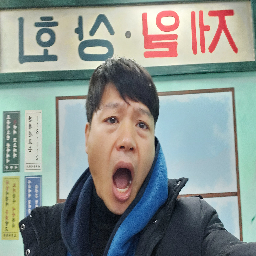

In [104]:
test_img[7]

In [ ]:
# df = pd.DataFrame(json_train, columns=['filename', 'faceExp_uploader'])
# df['faceExp_uploader'].unique()
# train_npz = np.load(TRAIN_SEGMENT_PATH + 'train_anger.npz')
# file_name = json_train[0]['filename']
# plt.imshow(train_npz[file_name], vmin=0, vmax=5)